# </font><font color='Blue'><b>Проект: «Снежная королева»</b></font><br>

**Металлургический комбинат «Стальная птица» обратился к нам с задачей уменьшения потребления электроэнергии на этапе обработки стали. Наша задача - предсказать температуру сплава. Сплав поготавливается следующим образом - в специальный ковш подаётся расплавленная сталь, далее она подогревается до нужной температуры с помощью электродов, в неё подаются добавки и продувают инертным газом. В течении этого процесса производятся замеры температуры и химический анализ сплава. При достижении нужных параметров сталь поступает в машину непрерывной разливки.**

**План работ для выполнения проекта:**
* изучение общей информации о предоставленных данных, проверка на соответствие данных поставленным задачам, целевым признаком является последняя измеренная температура
* предобработка и исследовательский анализ данных
* объединение данных в один датафрейм, его предобработка и исследовательский анализ
* подготовка данных для обучение модели и проверка её качества с помощью метрики. Метрикой определена MAE, её значение должно быть не более 6,8
* оформление вывода и предложение для предприятия

* **Делаем импорты**

In [1]:
!pip install matplotlib==3.5.0 -q
!pip install missingno -q
!pip install phik -q
!pip install scikit-learn==1.6.1 -q
!pip install shap -q

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import missingno as msno
import phik
import shap

from phik import phik_matrix, report, resources
from phik.report import plot_correlation_matrix

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, mean_absolute_error, mean_squared_error, roc_auc_score, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

* **Создаём функции**

In [4]:
def categorical_values(name, df):
    "Выводит значения категориальных признаков, тип 'object'"
    columns = df.select_dtypes(include='object').columns.tolist()
    if len(columns) > 0:
        print()
        print(f'Таблица "{name}"')
        print()
        for column in columns:
            print(f'cтолбец ["{column}"] содержит значения:')
            display(df[column].unique())
            print()
    print('---------------------------------------------------------------')

In [5]:
def duplicates(name, df, data_output):
    "Выводит количество дубликатов строк, для вывода дубликатов нужно ввести data_output = 1"
    print()
    if df.duplicated().sum() > 0:
        print(f'Количество дубликатов в таблице "{name}" равно {df.duplicated().sum()} шт.')
        if data_output == 1:
            display(df[df.duplicated()])
    else:
        print(f'Дубликаты в таблице "{name}" отсутствуют')
    print('---------------------------------------------------------------')

In [6]:
def info(name, df):
    "Выводит информацию о таблице"
    print()
    print(f'Выводим первые 5 строк таблицы "{name}":')
    display(df.head())
    print()
    print(f'Выводим общую информацию таблицы "{name}":')
    print()
    df.info()
    print()
    print(f'Выводим характеристики данных таблицы "{name}":')
    display(df.describe())
    print()
    print(f'Таблица "{name}" содержит {df.shape[0]} строк и {df.shape[1]} столбцов')
    print('---------------------------------------------------------------')

In [7]:
def missing_values(name, df, data_output):
    "Вывод информации о пропущенных данных, для вывода строк с пропущенными данными нужно ввести data_output = 1"
    print()
    if sum(df.isna().sum()) > 0:
        print(f'Пропущенные данные таблицы "{name}":')
        print()
        for column in df.columns:
            if df[column].isna().sum() > 0:
                print()
                print(f'- количество пропущенных данных столбца ["{column}"] = {df[column].isna().sum()} шт.')
                if data_output == 1:
                    display(df[df[column].isna()])
    else:
        print(f'В таблице "{name}" отсутствуют пропущенные данные')
    print('---------------------------------------------------------------')

In [8]:
def research(name, df, target):
    "Производит анализ признаков таблицы"
    print()
    print(f'Производим анализ признаков таблицы "{name}":')
    print('---------------------------------------------------------------')
    data = df.copy()
    data = data.drop('key', axis=1)
    qty_columns = data.select_dtypes(include='number').columns.tolist()
    cat_columns = data.select_dtypes(include='object').columns.tolist()
    sns.set()
    sns.set_style('whitegrid')
    for column in qty_columns:
        if data[column].dtypes in ['int32', 'int64'] and data[column].nunique() < 21:
            print(f'Выводим уникальные значения признака ["{column}"]')
            display(np.sort(data[column].unique()))
            print(f'Строим диаграмму признака ["{column}"]')
            fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
            if target != None:
                sns.countplot(data=data, x=column, hue=target)
            else:
                sns.countplot(data=data, x=column)
            axes.set_title(f'Диаграмма признака "{column}"', pad=25)
            axes.set_xlabel(column)
            axes.set_ylabel('Количество')
            plt.show()
            print('---------------------------------------------------------------')
        else:
            print(f'Выводим информацию о значениях признака ["{column}"]')
            display(data[column].describe())
            print(f'Строим гистограмму и диаграмму размаха признака ["{column}"]')
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
            if target != None:
                sns.histplot(data=data, x=column, ax=axes[0], kde=True, hue=target)
            else:
                sns.histplot(data=data, x=column, ax=axes[0], kde=True)
            axes[0].set_title(f'Гистограмма признака "{column}"', pad=25)
            axes[0].set_xlabel(column)
            axes[0].set_ylabel('Частота')
            sns.boxplot(data=data, x=column, ax=axes[1])
            axes[1].set_title(f'Диаграмма размаха признака "{column}"', pad=25)
            axes[1].set_xlabel(column)
            plt.show()
            print('---------------------------------------------------------------')
    #for column in cat_columns:
        #print(f'Строим круговую диаграмму признака ["{column}"]')
        #plt.figure(figsize=(7, 7))
        #plt.pie(data[column].value_counts(), labels=data[column].value_counts().index, autopct='%1.2f%%')
        #plt.title(f'Круговая диаграмма признака "{column}"')
        #plt.show()
        #print('---------------------------------------------------------------')

In [9]:
def size(name, df):
    "Выводит размер таблицы"
    print()
    print(f'Таблица "{name}" содержит {df.shape[0]} строк и {df.shape[1]} столбцов')
    print('---------------------------------------------------------------')

**Константы - задаём значения параметров random_state, test_size**

In [10]:
RANDOM_STATE = 190525
TEST_SIZE = 0.25

## Шаг 1. Загрузка данных

**Сохраняем данные в таблицы (приводим даты к формату 'datetime')**

In [11]:
data_arc_new = pd.read_csv('/datasets/data_arc_new.csv', parse_dates=[1, 2])
data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv', parse_dates=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
data_temp_new = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=[1])
data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv', parse_dates=[1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
dfs = {'data_arc_new': data_arc_new, 'data_bulk_new': data_bulk_new, 'data_bulk_time_new': data_bulk_time_new, 'data_gas_new': data_gas_new, 'data_temp_new': data_temp_new, 'data_wire_new': data_wire_new, 'data_wire_time_new': data_wire_time_new} # словарь с таблицами
for name, df in dfs.items():
    info(name, df)


Выводим первые 5 строк таблицы "data_arc_new":


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



Выводим общую информацию таблицы "data_arc_new":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB

Выводим характеристики данных таблицы "data_arc_new":


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



Таблица "data_arc_new" содержит 14876 строк и 5 столбцов
---------------------------------------------------------------

Выводим первые 5 строк таблицы "data_bulk_new":


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Выводим общую информацию таблицы "data_bulk_new":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Выводим характеристики данных таблицы "data_bulk_new":


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Таблица "data_bulk_new" содержит 3129 строк и 16 столбцов
---------------------------------------------------------------

Выводим первые 5 строк таблицы "data_bulk_time_new":


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47



Выводим общую информацию таблицы "data_bulk_time_new":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15)

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



Таблица "data_bulk_time_new" содержит 3129 строк и 16 столбцов
---------------------------------------------------------------

Выводим первые 5 строк таблицы "data_gas_new":


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Выводим общую информацию таблицы "data_gas_new":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Выводим характеристики данных таблицы "data_gas_new":


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Таблица "data_gas_new" содержит 3239 строк и 2 столбцов
---------------------------------------------------------------

Выводим первые 5 строк таблицы "data_temp_new":


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



Выводим общую информацию таблицы "data_temp_new":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB

Выводим характеристики данных таблицы "data_temp_new":


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000



Таблица "data_temp_new" содержит 18092 строк и 3 столбцов
---------------------------------------------------------------

Выводим первые 5 строк таблицы "data_wire_new":


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Выводим общую информацию таблицы "data_wire_new":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Выводим характеристики данных таблицы "data_wire_new":


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Таблица "data_wire_new" содержит 3081 строк и 10 столбцов
---------------------------------------------------------------

Выводим первые 5 строк таблицы "data_wire_time_new":


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT



Выводим общую информацию таблицы "data_wire_time_new":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB

Выводим характеристики данных таблицы "data_wire_time_new":


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



Таблица "data_wire_time_new" содержит 3081 строк и 10 столбцов
---------------------------------------------------------------


**Приведём названия столбцов таблиц к общепринятому стилю**

* **Таблица 'data_arc_new'**

In [13]:
data_arc_new = data_arc_new.rename(columns={'Начало нагрева дугой': 'start_arc_heating', 'Конец нагрева дугой': 'end_arc_heating', 'Активная мощность': 'active_power', 'Реактивная мощность': 'reactive_power'})
data_arc_new.columns

Index(['key', 'start_arc_heating', 'end_arc_heating', 'active_power',
       'reactive_power'],
      dtype='object')

* **Таблица 'data_bulk_new'**

In [14]:
data_bulk_new.columns = data_bulk_new.columns.str.lower().str.replace(' ', '_')
data_bulk_new.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

* **Таблица 'data_bulk_time_new'**

In [15]:
data_bulk_time_new.columns = data_bulk_time_new.columns.str.lower().str.replace(' ', '_')
data_bulk_time_new.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

* **Таблица 'data_gas_new'**

In [16]:
data_gas_new = data_gas_new.rename(columns={'Газ 1': 'gas'})
data_gas_new.columns

Index(['key', 'gas'], dtype='object')

* **Таблица 'data_temp_new'**

In [17]:
data_temp_new = data_temp_new.rename(columns={'Время замера': 'time_measuring', 'Температура': 'temperature'})
data_temp_new.columns

Index(['key', 'time_measuring', 'temperature'], dtype='object')

* **Таблица 'data_wire_new'**

In [18]:
data_wire_new.columns = data_wire_new.columns.str.lower().str.replace(' ', '_')
data_wire_new.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

* **Таблица 'data_wire_time_new'**

In [19]:
data_wire_time_new.columns = data_wire_time_new.columns.str.lower().str.replace(' ', '_')
data_wire_time_new.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

***Для проведения исследования получены 7 файлов с данными:***
* data_arc_new.csv - с данными об электродах
* data_bulk_new.csv - с данные об объёме подачи сыпучих материалов
* data_bulk_time_new.csv - с данными о времени подачи сыпучих материалов
* data_gas_new.csv - с данными о продувке сплава газом
* data_temp_new.csv - с результатами измерения температуры
* data_wire_new.csv - с данными об объёме подачи проволочных материалов
* data_wire_time_new.csv - с данными о времени подачи проволочных материалов

***С этими файлами были произведены следующие действия:***
* загружены и сохранены данные используя библиотеку pandas, даты приведены к формату 'datetime'
* выведены первые строки таблиц
* получена общая информация о таблицах

***Изучив данные можно сделать следующие выводы:***
* в таблицах присутствуют данные количественные, категориальные и обозначающие дату и время: номер партии, время начала и окончания нагрева, объём и время подачи материала, объём подаваемого газа, значение температуры и время её замера, объём и время подачи проволочных материалов
* в названиях столбцов присутствуют символы в верхнем регистре, пробелы и кириллица. Приводим названия столбцов к общепринятому стилю: латиница, нижний регистр и нижнее подчёркивание в качестве разделителя
* в некоторых таблицах присутствуют пропущенные данные
* в таблице 'data_arc_new' присутствует аномалия - отрицательное значение в столбце 'реактивная мощность'. В других таблицах явных аномалий не наблюдается
* таблица 'data_temp_new' содержит целевой признак - последнее значение температуры
* типы данных во всех таблицах соответствует назначению данных

## Шаг 2. Исследовательский анализ и предобработка данных

**Проверяем наличие пропущенных данных в таблицах**

In [20]:
dfs = {'data_arc_new': data_arc_new, 'data_bulk_new': data_bulk_new, 'data_bulk_time_new': data_bulk_time_new, 'data_gas_new': data_gas_new, 'data_temp_new': data_temp_new, 'data_wire_new': data_wire_new, 'data_wire_time_new': data_wire_time_new} # словарь с таблицами
for name, df in dfs.items():
    missing_values(name, df, 0)


В таблице "data_arc_new" отсутствуют пропущенные данные
---------------------------------------------------------------

Пропущенные данные таблицы "data_bulk_new":


- количество пропущенных данных столбца ["bulk_1"] = 2877 шт.

- количество пропущенных данных столбца ["bulk_2"] = 3107 шт.

- количество пропущенных данных столбца ["bulk_3"] = 1831 шт.

- количество пропущенных данных столбца ["bulk_4"] = 2115 шт.

- количество пропущенных данных столбца ["bulk_5"] = 3052 шт.

- количество пропущенных данных столбца ["bulk_6"] = 2553 шт.

- количество пропущенных данных столбца ["bulk_7"] = 3104 шт.

- количество пропущенных данных столбца ["bulk_8"] = 3128 шт.

- количество пропущенных данных столбца ["bulk_9"] = 3110 шт.

- количество пропущенных данных столбца ["bulk_10"] = 2953 шт.

- количество пропущенных данных столбца ["bulk_11"] = 2952 шт.

- количество пропущенных данных столбца ["bulk_12"] = 679 шт.

- количество пропущенных данных столбца ["bulk_13"] = 3111 шт.

- количест

* ***В парах таблиц 'data_bulk_new' - 'data_bulk_time_new' и 'data_wire_new' - 'data_wire_time_new' присутствует одинаковое количество пропущенных данных в столбцах с одним названием, что говорит о том, что если отсутствует данные об объёме подачи сыпучих или проволочных материалов, то также отсутствуют и данные о времени подачи этих материалов. Делаем вывод, что отсутствующие значения обозначают, что материалы не подавались в этом шаге, следовательно их заменим на значение 0***

In [21]:
data_bulk_new = data_bulk_new.fillna(0)
data_wire_new = data_wire_new.fillna(0)

* **Удаляем данные тех партий в таблице 'data_temp_new', у которых пропущено последнее значение температуры, так как это значение является целевым признаком**

In [22]:
# определяем номера партий, в которых пропущено последнее значение температуры - получаем таблицу только с такими данными
key_data_temp_new = data_temp_new[data_temp_new['temperature'].isna()].\
                    sort_values(['key', 'time_measuring'], ascending=[True, False]).\
                    drop_duplicates(['key']).reset_index(drop=True)
# удаляем эти партии
for k in key_data_temp_new['key'].unique():
    data_temp_new = data_temp_new.drop(data_temp_new[data_temp_new['key'] == k].index, axis=0).reset_index(drop=True)

* **Ещё раз проверяем наличие пропущенных данных в таблицах**

In [23]:
dfs = {'data_arc_new': data_arc_new, 'data_bulk_new': data_bulk_new, 'data_bulk_time_new': data_bulk_time_new, 'data_gas_new': data_gas_new, 'data_temp_new': data_temp_new, 'data_wire_new': data_wire_new, 'data_wire_time_new': data_wire_time_new} # словарь с таблицами
for name, df in dfs.items():
    missing_values(name, df, 0)


В таблице "data_arc_new" отсутствуют пропущенные данные
---------------------------------------------------------------

В таблице "data_bulk_new" отсутствуют пропущенные данные
---------------------------------------------------------------

Пропущенные данные таблицы "data_bulk_time_new":


- количество пропущенных данных столбца ["bulk_1"] = 2877 шт.

- количество пропущенных данных столбца ["bulk_2"] = 3107 шт.

- количество пропущенных данных столбца ["bulk_3"] = 1831 шт.

- количество пропущенных данных столбца ["bulk_4"] = 2115 шт.

- количество пропущенных данных столбца ["bulk_5"] = 3052 шт.

- количество пропущенных данных столбца ["bulk_6"] = 2553 шт.

- количество пропущенных данных столбца ["bulk_7"] = 3104 шт.

- количество пропущенных данных столбца ["bulk_8"] = 3128 шт.

- количество пропущенных данных столбца ["bulk_9"] = 3110 шт.

- количество пропущенных данных столбца ["bulk_10"] = 2953 шт.

- количество пропущенных данных столбца ["bulk_11"] = 2952 шт.

- количест

**Проверяем наличие дубликатов в таблицах**

In [24]:
for name, df in dfs.items():
    duplicates(name, df, 0)


Дубликаты в таблице "data_arc_new" отсутствуют
---------------------------------------------------------------

Дубликаты в таблице "data_bulk_new" отсутствуют
---------------------------------------------------------------

Дубликаты в таблице "data_bulk_time_new" отсутствуют
---------------------------------------------------------------

Дубликаты в таблице "data_gas_new" отсутствуют
---------------------------------------------------------------

Дубликаты в таблице "data_temp_new" отсутствуют
---------------------------------------------------------------

Дубликаты в таблице "data_wire_new" отсутствуют
---------------------------------------------------------------

Дубликаты в таблице "data_wire_time_new" отсутствуют
---------------------------------------------------------------


**В таблице 'data_arc_new' присутствует отрицательное значение реактивной мощности. Реактивная мощность может иметь отрицательное значение, выведем такие строки**

In [25]:
data_arc_new.query('reactive_power < 0')

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


* ***Мы получили одну строку с отрицательным значением реактивной мощности. ~~Так как это значение существенно превосходит по размеру медиану (0,44), то считаем это аномалией и удаляем данное значение~~ Рассмотрим все значения в этой партии***

In [26]:
data_arc_new.query('key == 2116')

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


* **Отрицательное значение значительно превосходит другие значения реактивной мощности в этой партию и является аномалией. Заменим аномалию на среднее значение реактивной мощности в этой партии**

In [27]:
#data_arc_new = data_arc_new.drop(data_arc_new[data_arc_new['reactive_power'] < 0].index, axis=0).reset_index(drop=True)
data_arc_new.loc[(data_arc_new['key'] == 2116) & (data_arc_new['reactive_power'] < 0), 'reactive_power'] = \
    data_arc_new.loc[(data_arc_new['key'] == 2116) & (data_arc_new['reactive_power'] >= 0), 'reactive_power'].mean()
data_arc_new.query('key == 2116')

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,0.504631
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


**Производим анализ признаков**


Производим анализ признаков таблицы "data_arc_new":
---------------------------------------------------------------
Выводим информацию о значениях признака ["active_power"]


count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: active_power, dtype: float64

Строим гистограмму и диаграмму размаха признака ["active_power"]


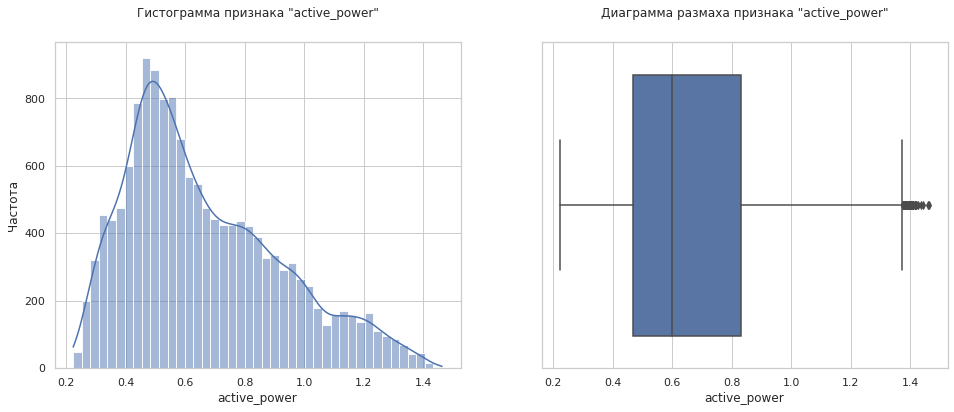

---------------------------------------------------------------
Выводим информацию о значениях признака ["reactive_power"]


count    14876.000000
mean         0.487117
std          0.197606
min          0.153777
25%          0.337192
50%          0.441667
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64

Строим гистограмму и диаграмму размаха признака ["reactive_power"]


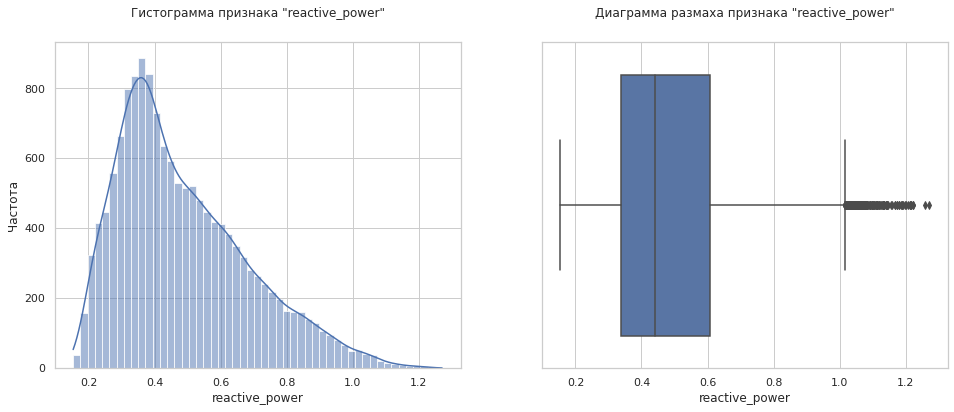

---------------------------------------------------------------

Производим анализ признаков таблицы "data_bulk_new":
---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_1"]


count    3129.000000
mean        3.160435
std        11.869164
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       185.000000
Name: bulk_1, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_1"]


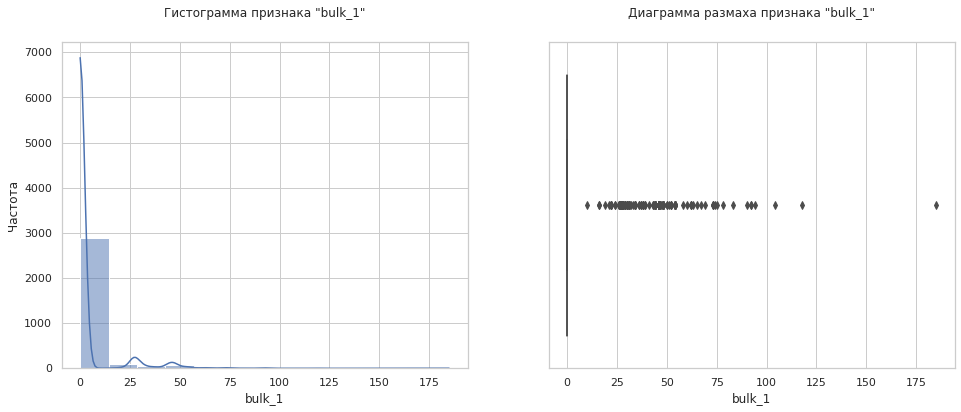

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_2"]


count    3129.000000
mean        1.779163
std        21.217878
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       325.000000
Name: bulk_2, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_2"]


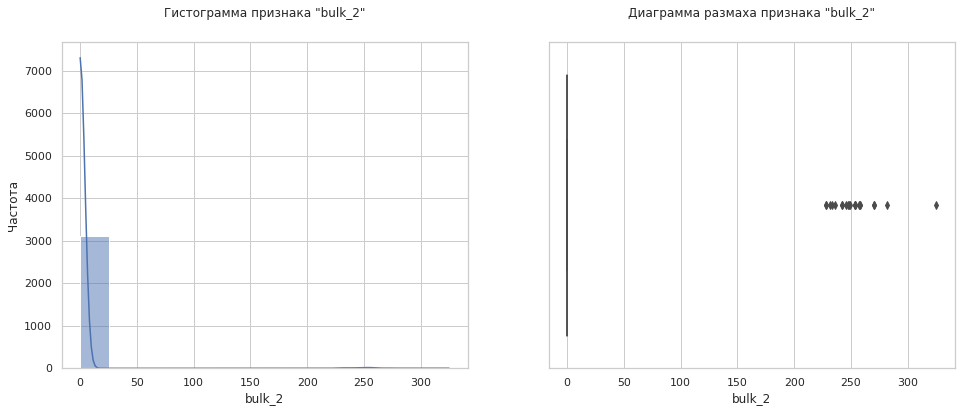

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_3"]


count    3129.000000
mean       47.240332
std        74.239954
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: bulk_3, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_3"]


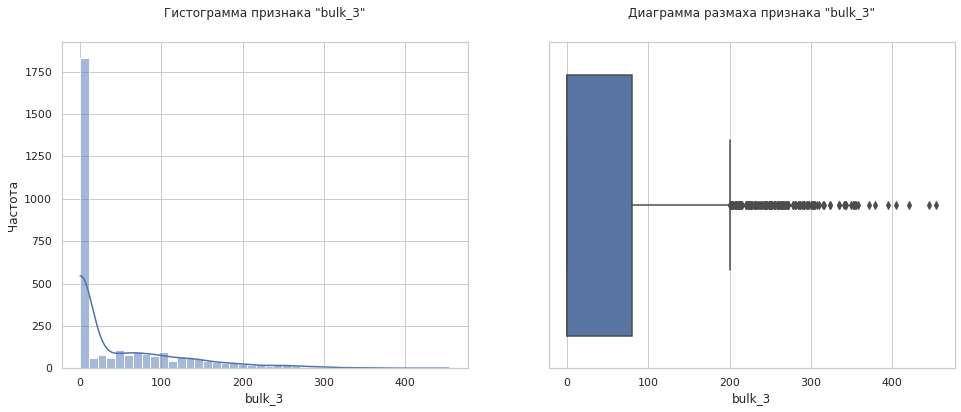

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_4"]


count    3129.000000
mean       33.830617
std        56.034505
min         0.000000
25%         0.000000
50%         0.000000
75%        68.000000
max       281.000000
Name: bulk_4, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_4"]


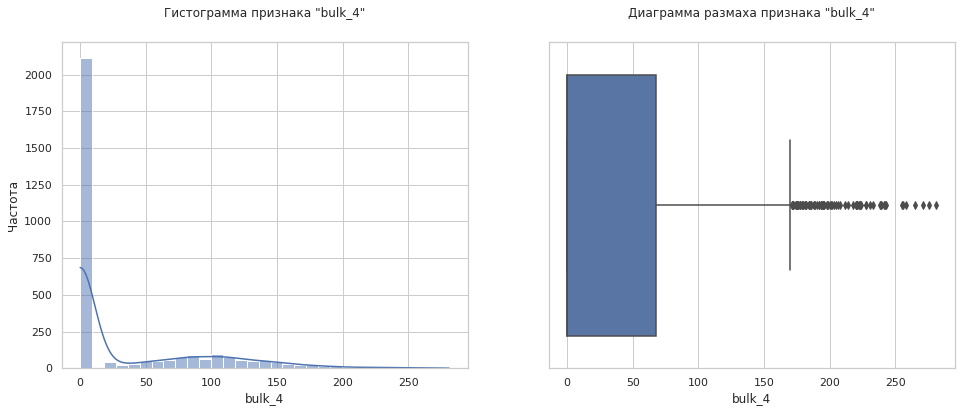

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_5"]


count    3129.000000
mean        2.633749
std        20.918138
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       603.000000
Name: bulk_5, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_5"]


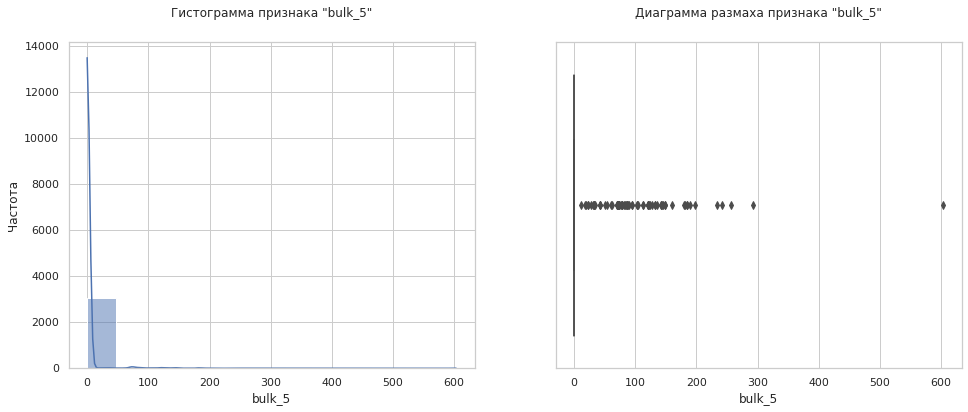

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_6"]


count    3129.000000
mean       21.892298
std        55.492582
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       503.000000
Name: bulk_6, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_6"]


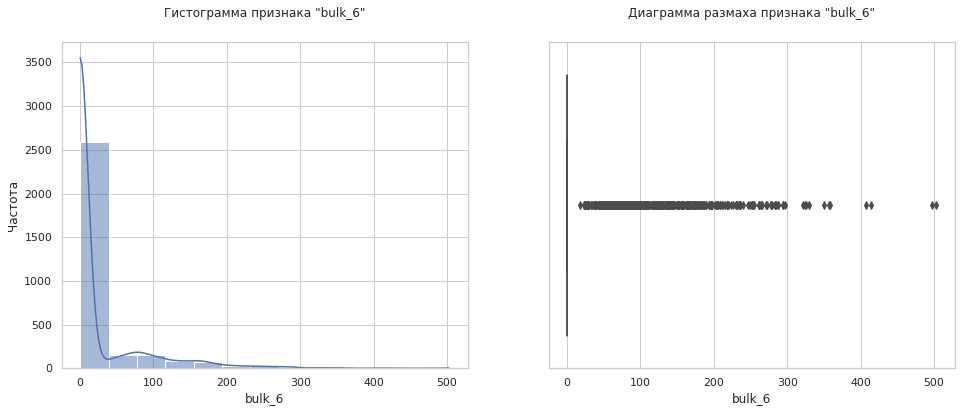

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_7"]


count    3129.000000
mean        2.441675
std        31.944063
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       772.000000
Name: bulk_7, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_7"]


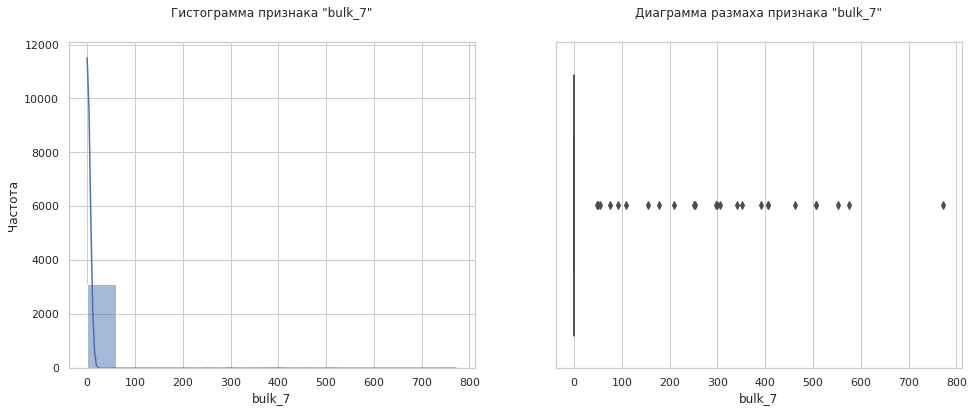

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_8"]


count    3129.000000
mean        0.015660
std         0.875978
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        49.000000
Name: bulk_8, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_8"]


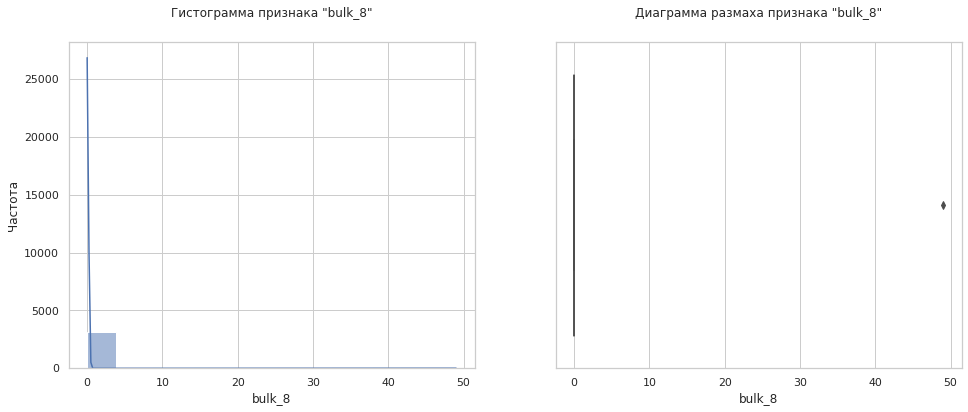

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_9"]


count    3129.000000
mean        0.463407
std         6.154398
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       147.000000
Name: bulk_9, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_9"]


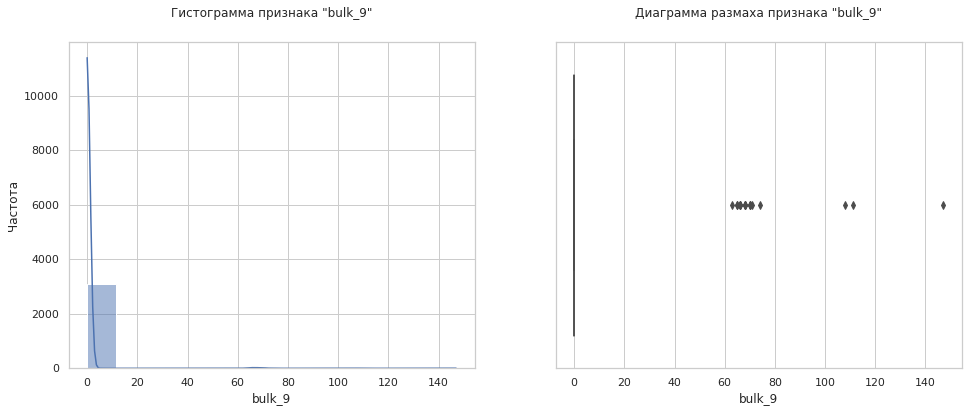

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_10"]


count    3129.000000
mean        4.684564
std        20.157323
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       159.000000
Name: bulk_10, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_10"]


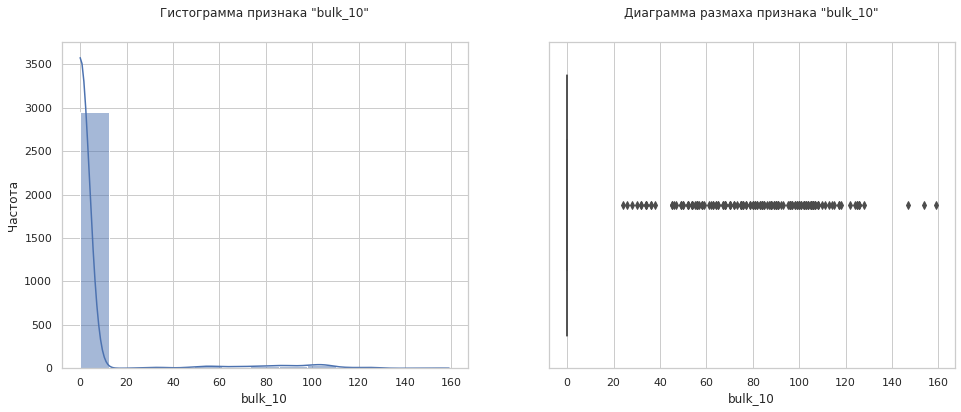

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_11"]


count    3129.000000
mean        4.345478
std        22.699580
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       313.000000
Name: bulk_11, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_11"]


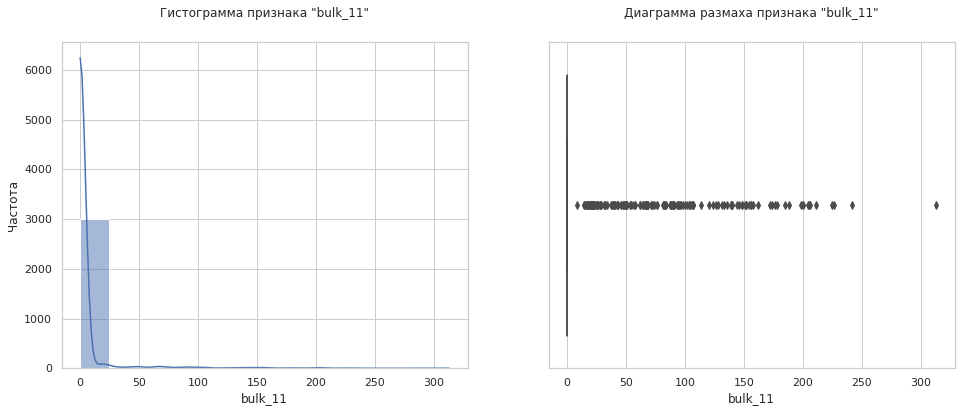

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_12"]


count    3129.000000
mean      203.948226
std       151.419639
min         0.000000
25%       105.000000
50%       206.000000
75%       263.000000
max      1849.000000
Name: bulk_12, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_12"]


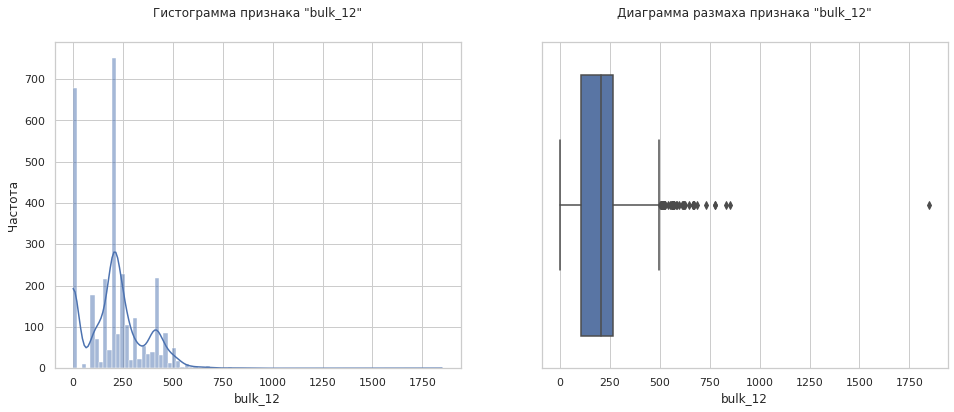

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_13"]


count    3129.000000
mean        1.041866
std        14.114252
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       305.000000
Name: bulk_13, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_13"]


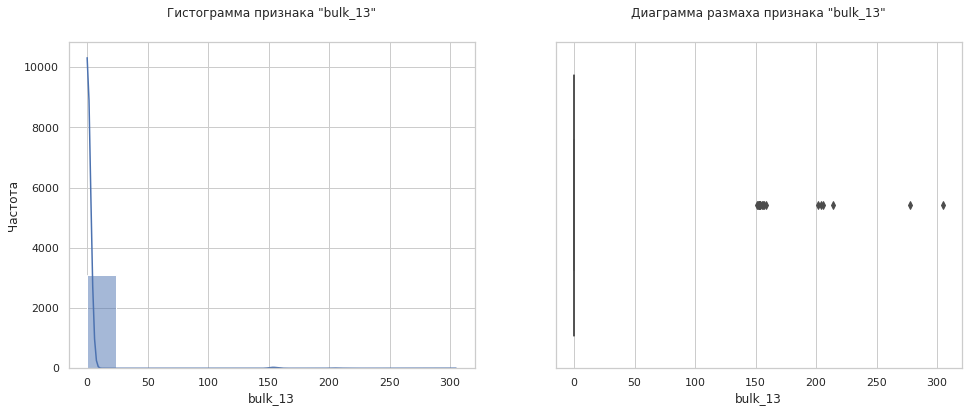

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_14"]


count    3129.000000
mean      152.706616
std        81.091421
min         0.000000
25%       104.000000
50%       148.000000
75%       202.000000
max       636.000000
Name: bulk_14, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_14"]


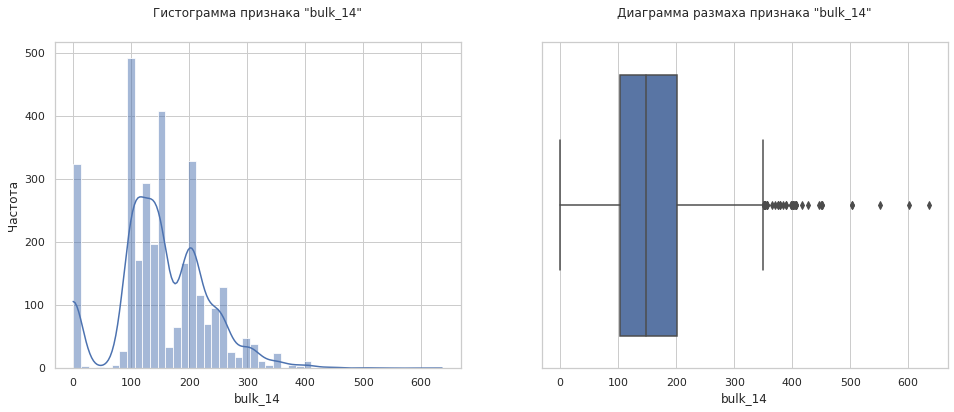

---------------------------------------------------------------
Выводим информацию о значениях признака ["bulk_15"]


count    3129.000000
mean      115.319271
std        84.488698
min         0.000000
25%         0.000000
50%       106.000000
75%       204.000000
max       405.000000
Name: bulk_15, dtype: float64

Строим гистограмму и диаграмму размаха признака ["bulk_15"]


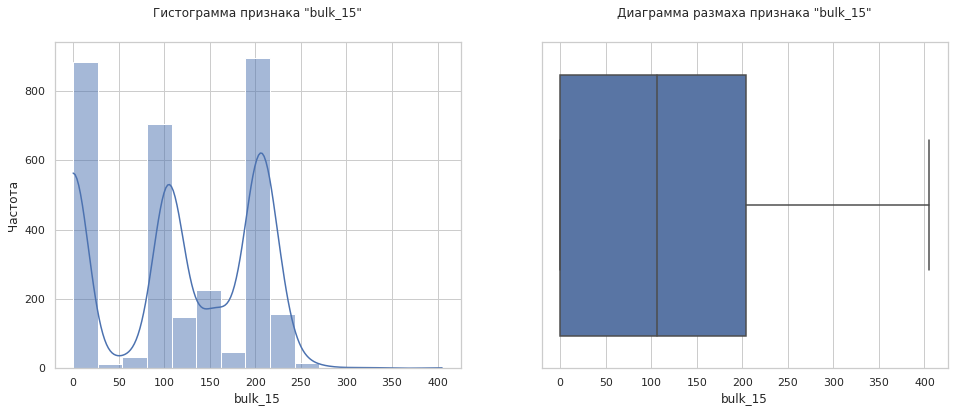

---------------------------------------------------------------

Производим анализ признаков таблицы "data_gas_new":
---------------------------------------------------------------
Выводим информацию о значениях признака ["gas"]


count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas, dtype: float64

Строим гистограмму и диаграмму размаха признака ["gas"]


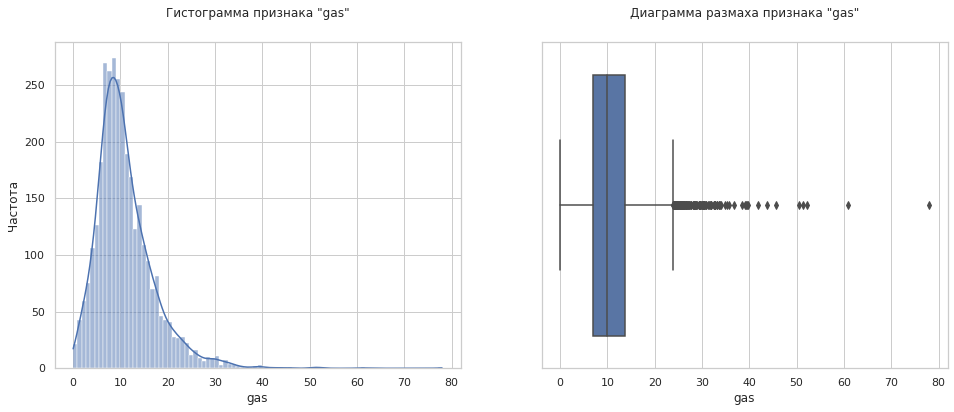

---------------------------------------------------------------

Производим анализ признаков таблицы "data_temp_new":
---------------------------------------------------------------
Выводим информацию о значениях признака ["temperature"]


count    13926.000000
mean      1590.802671
std         19.845377
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temperature, dtype: float64

Строим гистограмму и диаграмму размаха признака ["temperature"]


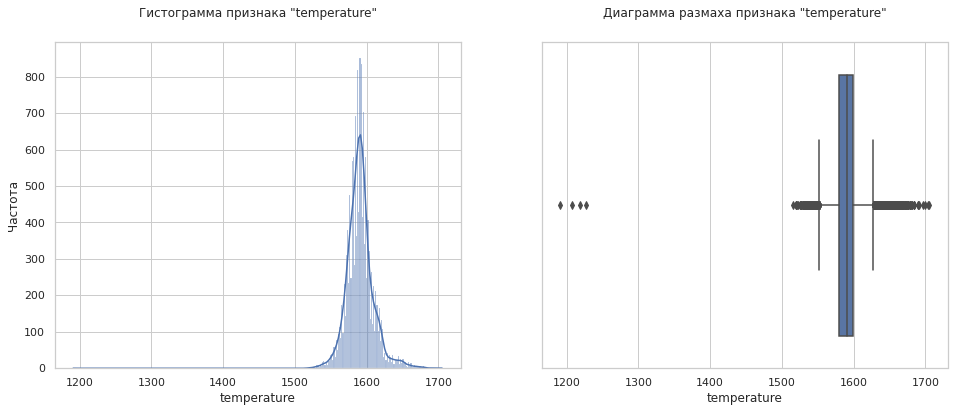

---------------------------------------------------------------

Производим анализ признаков таблицы "data_wire_new":
---------------------------------------------------------------
Выводим информацию о значениях признака ["wire_1"]


count    3081.000000
mean      100.044411
std        42.841120
min         0.000000
25%        70.281120
50%       100.114563
75%       125.798405
max       330.314424
Name: wire_1, dtype: float64

Строим гистограмму и диаграмму размаха признака ["wire_1"]


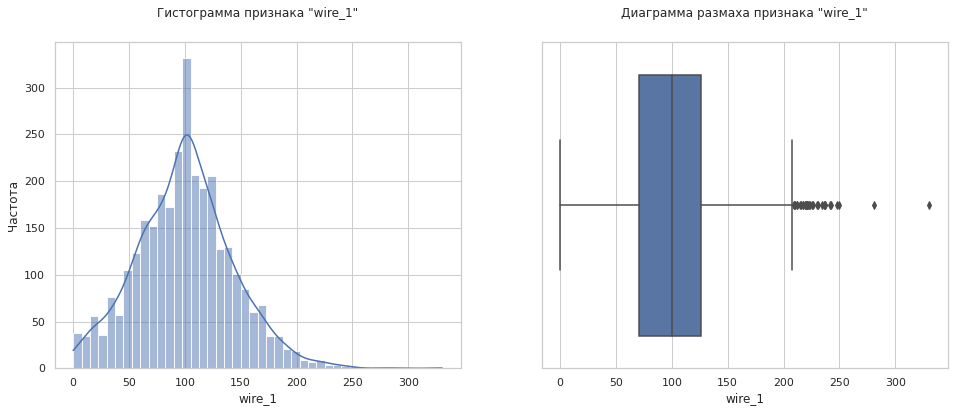

---------------------------------------------------------------
Выводим информацию о значениях признака ["wire_2"]


count    3081.000000
mean       17.712733
std        33.517734
min         0.000000
25%         0.000000
50%         0.000000
75%        23.162880
max       282.780152
Name: wire_2, dtype: float64

Строим гистограмму и диаграмму размаха признака ["wire_2"]


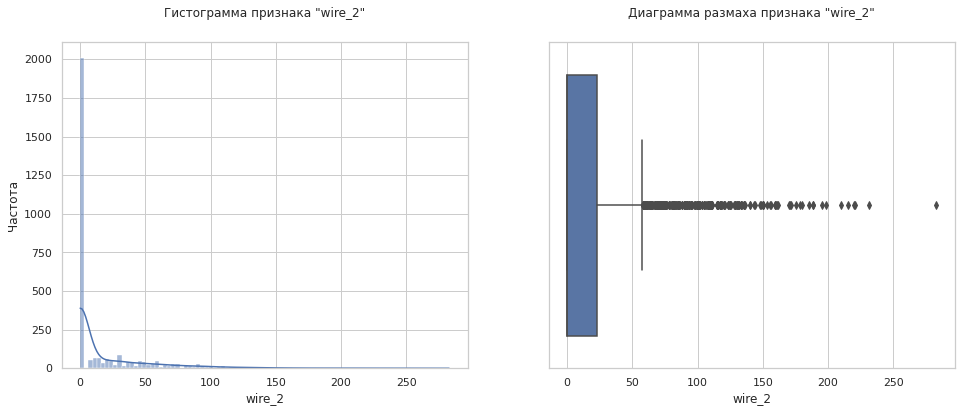

---------------------------------------------------------------
Выводим информацию о значениях признака ["wire_3"]


count    3081.000000
mean        3.874524
std        30.310417
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       385.008668
Name: wire_3, dtype: float64

Строим гистограмму и диаграмму размаха признака ["wire_3"]


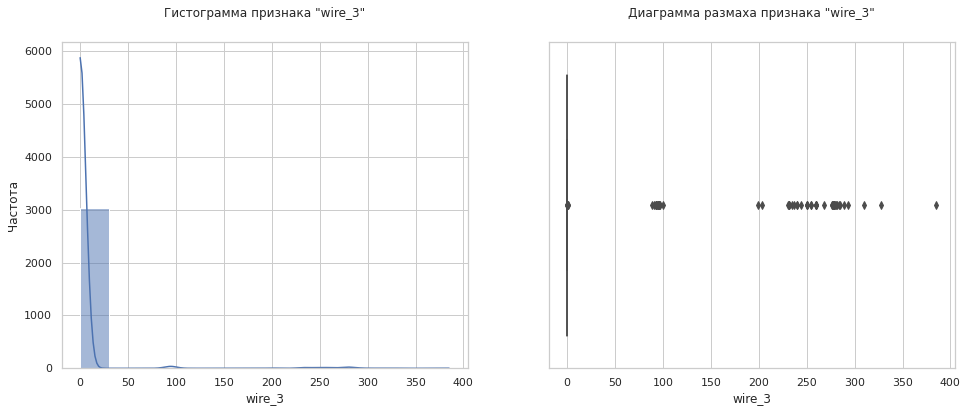

---------------------------------------------------------------
Выводим информацию о значениях признака ["wire_4"]


count    3081.000000
mean        0.261019
std         4.293865
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       113.231044
Name: wire_4, dtype: float64

Строим гистограмму и диаграмму размаха признака ["wire_4"]


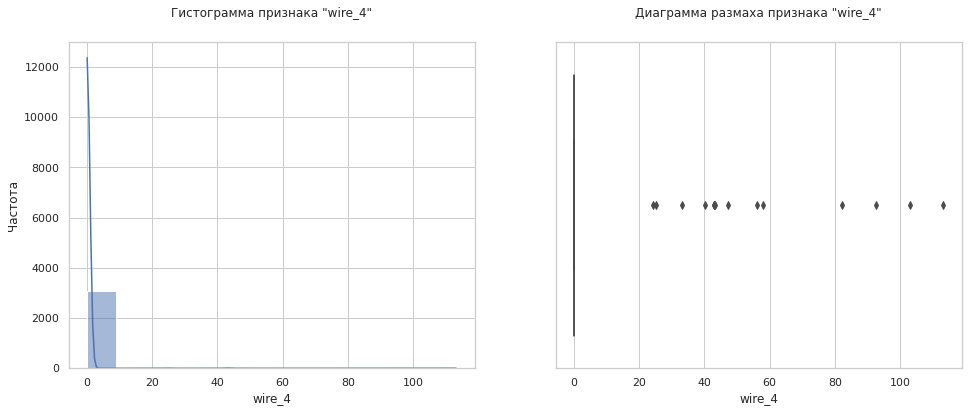

---------------------------------------------------------------
Выводим информацию о значениях признака ["wire_5"]


count    3081.000000
mean        0.004911
std         0.272615
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        15.132000
Name: wire_5, dtype: float64

Строим гистограмму и диаграмму размаха признака ["wire_5"]


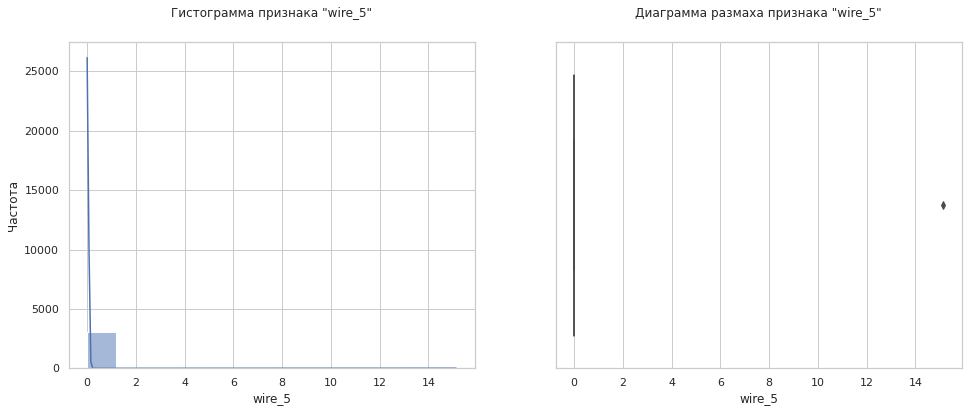

---------------------------------------------------------------
Выводим информацию о значениях признака ["wire_6"]


count    3081.000000
mean        1.137695
std         8.958111
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       180.454575
Name: wire_6, dtype: float64

Строим гистограмму и диаграмму размаха признака ["wire_6"]


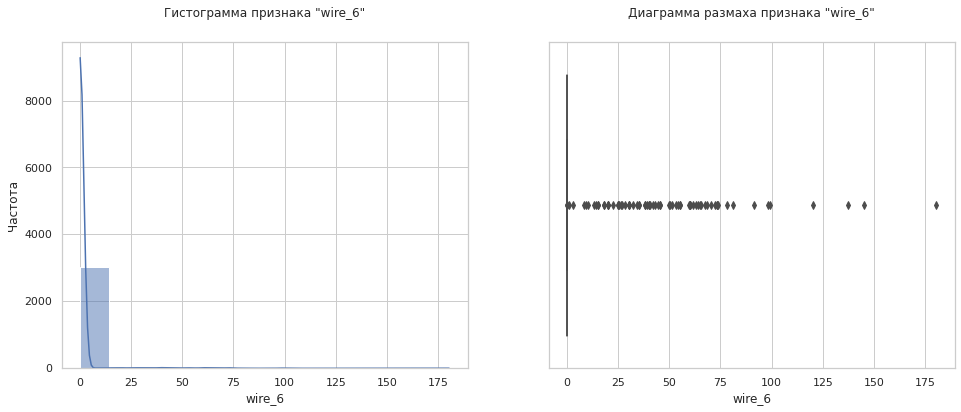

---------------------------------------------------------------
Выводим информацию о значениях признака ["wire_7"]


count    3081.000000
mean        0.035842
std         0.774190
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        32.847674
Name: wire_7, dtype: float64

Строим гистограмму и диаграмму размаха признака ["wire_7"]


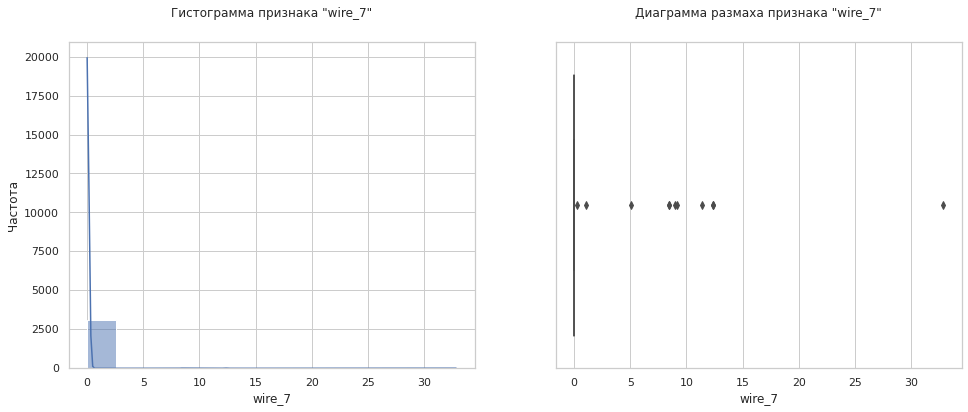

---------------------------------------------------------------
Выводим информацию о значениях признака ["wire_8"]


count    3081.000000
mean        0.330697
std         4.392677
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       102.762401
Name: wire_8, dtype: float64

Строим гистограмму и диаграмму размаха признака ["wire_8"]


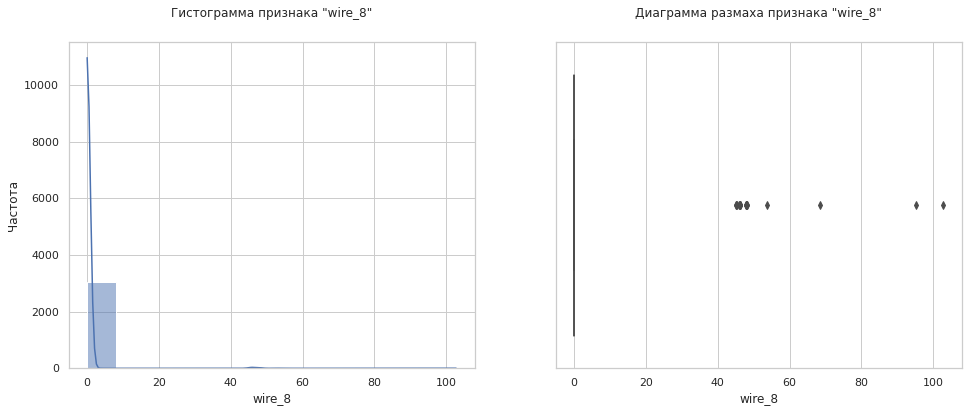

---------------------------------------------------------------
Выводим информацию о значениях признака ["wire_9"]


count    3081.000000
mean        0.321492
std         3.806904
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        90.053604
Name: wire_9, dtype: float64

Строим гистограмму и диаграмму размаха признака ["wire_9"]


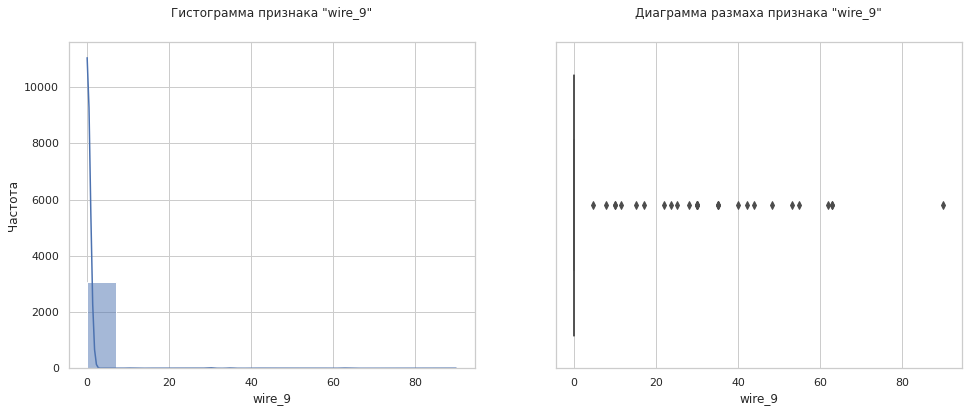

---------------------------------------------------------------


In [28]:
dfs = {'data_arc_new': data_arc_new, 'data_bulk_new': data_bulk_new, 'data_gas_new': data_gas_new, 'data_temp_new': data_temp_new, 'data_wire_new': data_wire_new} # словарь с таблицами
for name, df in dfs.items():
    research(name, df, None)

* ***В таблице 'data_temp_new' в столбце 'temperature' наблюдаются аномальные значения в диапазоне менее 1300***

In [29]:
data_temp_new.query('temperature < 1300')

,key,time_measuring,temperature
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0


* **Удаляем строки с этими значениями температуры из таблицы 'data_temp_new'**

In [30]:
data_temp_new = data_temp_new.drop(data_temp_new[data_temp_new['temperature'] < 1300].index, axis=0).reset_index(drop=True)

**Добавляем в таблицу 'data_arc_new' столбец с полной мощностью**

In [31]:
data_arc_new['full_power'] = (data_arc_new['active_power'] ** 2 + data_arc_new['reactive_power'] ** 2) ** 0.5

**Добавляем в таблицу 'data_arc_new' столбец с временем нагрева в секундах**

In [32]:
data_arc_new['time_heating'] = (data_arc_new['end_arc_heating'] - data_arc_new['start_arc_heating']).dt.total_seconds()

**Добавляем в таблицу 'data_arc_new' столбец с интервалами между нагревами в секундах**

In [33]:
key_arc_group = data_arc_new.groupby('key')

def interval_heating(data):
    data['interval_heating'] = (data['start_arc_heating'] - data['end_arc_heating'].shift(periods=1)).dt.total_seconds().fillna(0)
    return data

data_arc_new = key_arc_group.apply(interval_heating)

**Добавляем в таблицу 'data_arc_new' столбец с количеством циклов нагрева в каждой партии**

In [34]:
data_arc_new['cycles_heating'] = data_arc_new.groupby('key')['key'].transform('count')
data_arc_new.head()

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,full_power,time_heating,interval_heating,cycles_heating
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0,0.0,5
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0,86.0,5
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0,71.0,5
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0,218.0,5
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0,110.0,5


**Создаём сводную таблицу на базе таблицы 'data_arc_new' для каждой партии с суммарными значениями**

In [35]:
data_arc_new_key = data_arc_new.pivot_table(index='key', \
                   values=['active_power', 'reactive_power', 'full_power', 'time_heating', 'interval_heating', \
                          'cycles_heating', 'start_arc_heating', 'end_arc_heating'], \
                   aggfunc={'active_power': 'sum', 'reactive_power': 'sum', 'full_power': 'sum', \
                           'time_heating': 'sum', 'interval_heating': 'sum', 'cycles_heating': 'mean', \
                           'start_arc_heating': 'first', 'end_arc_heating': 'last'}).reset_index()
data_arc_new_key.head()

,key,active_power,cycles_heating,end_arc_heating,full_power,interval_heating,reactive_power,start_arc_heating,time_heating
0,1,3.036730,5,2019-05-03 11:28:37,3.718736,485.0,2.142821,2019-05-03 11:02:14,1098.0
1,2,2.139408,4,2019-05-03 11:53:18,2.588349,333.0,1.453357,2019-05-03 11:34:14,811.0
2,3,4.063641,5,2019-05-03 12:32:19,5.019223,870.0,2.937457,2019-05-03 12:06:54,655.0
3,4,2.706489,4,2019-05-03 12:57:50,3.400038,352.0,2.056992,2019-05-03 12:39:37,741.0
4,5,2.252950,4,2019-05-03 13:33:55,2.816980,493.0,1.687991,2019-05-03 13:11:13,869.0


**Добавляем в таблицу 'data_bulk_new' столбцы с суммой объёма подачи сыпучих материалов и количеством подач. Удаляем столбцы 'bulk'**

In [36]:
data_bulk_new['full_bulk'] = data_bulk_new.drop('key', axis=1).sum(axis=1)
data_bulk_new['cycles_bulk'] = data_bulk_new[data_bulk_new > 0].drop(['key', 'full_bulk'], axis=1).count(axis=1)
data_bulk_new = data_bulk_new.drop(data_bulk_new.columns[1:16], axis=1)
data_bulk_new.head()

,key,full_bulk,cycles_bulk
0,1,553.0,4
1,2,582.0,4
2,3,544.0,4
3,4,595.0,4
4,5,584.0,4


**Добавляем в таблицу 'data_bulk_time_new' время, прошедшее с начала добавления сыпучих материалов до окончания. Удаляем столбцы 'bulk'**

In [37]:
data_bulk_time_new['start_bulk'] = data_bulk_time_new.drop('key', axis=1).min(axis=1)
data_bulk_time_new['end_bulk'] = data_bulk_time_new.drop('key', axis=1).max(axis=1)
data_bulk_time_new['time_bulk'] = (data_bulk_time_new['end_bulk'] - data_bulk_time_new['start_bulk']).dt.total_seconds()
data_bulk_time_new = data_bulk_time_new.drop(data_bulk_time_new.columns[1:18], axis=1)
data_bulk_time_new.head()

,key,time_bulk
0,1,1085.0
1,2,1000.0
2,3,983.0
3,4,878.0
4,5,205.0


**Добавляем в таблицу 'data_wire_new' столбцы с суммой объёма подачи проволочных материалов и количеством подач. Удаляем столбцы 'wire'**

In [38]:
data_wire_new['full_wire'] = data_wire_new.drop('key', axis=1).sum(axis=1)
data_wire_new['cycles_wire'] = data_wire_new[data_wire_new > 0].drop(['key', 'full_wire'], axis=1).count(axis=1)
data_wire_new = data_wire_new.drop(data_wire_new.columns[1:10], axis=1)
data_wire_new.head()

,key,full_wire,cycles_wire
0,1,60.059998,1
1,2,96.052315,1
2,3,91.160157,1
3,4,89.063515,1
4,5,98.352796,2


**Добавляем в таблицу 'data_wire_time_new' время, прошедшее с начала добавления проволочных материалов до окончания. Удаляем столбцы 'wire'**

In [39]:
data_wire_time_new['start_wire'] = data_wire_time_new.drop('key', axis=1).min(axis=1)
data_wire_time_new['end_wire'] = data_wire_time_new.drop('key', axis=1).max(axis=1)
data_wire_time_new['time_wire'] = (data_wire_time_new['end_wire'] - data_wire_time_new['start_wire']).dt.total_seconds()
data_wire_time_new = data_wire_time_new.drop(data_wire_time_new.columns[1:12], axis=1)
data_wire_time_new.head()

,key,time_wire
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,310.0


**Добавляем в таблицу 'data_temp_new' столбцы с интервалами между замерами температуры и количеством циклов замеров**

In [40]:
data_temp_new['interval_time'] = data_temp_new.groupby('key')['time_measuring'].diff().dt.total_seconds().fillna(0)
data_temp_new['cycles_temperature'] = data_temp_new.groupby('key')['key'].transform('count')
data_temp_new['start_time_measuring'] = data_temp_new.groupby('key')['time_measuring'].transform('min')
data_temp_new['end_time_measuring'] = data_temp_new.groupby('key')['time_measuring'].transform('max')
data_temp_new.head()

,key,time_measuring,temperature,interval_time,cycles_temperature,start_time_measuring,end_time_measuring
0,1,2019-05-03 11:02:04,1571.0,0.0,6,2019-05-03 11:02:04,2019-05-03 11:30:38
1,1,2019-05-03 11:07:18,1604.0,314.0,6,2019-05-03 11:02:04,2019-05-03 11:30:38
2,1,2019-05-03 11:11:34,1618.0,256.0,6,2019-05-03 11:02:04,2019-05-03 11:30:38
3,1,2019-05-03 11:18:04,1601.0,390.0,6,2019-05-03 11:02:04,2019-05-03 11:30:38
4,1,2019-05-03 11:25:59,1606.0,475.0,6,2019-05-03 11:02:04,2019-05-03 11:30:38


**Создаём сводную таблицу на базе таблицы 'data_temp_new' с суммарными значениями для каждой партии, оставляем начальное и конечное значения температур - целевой признак~~, а также их минимальное и максимальное значения~~**

In [41]:
data_temp_new_key = data_temp_new.pivot_table(index='key', \
                   values=['temperature', 'interval_time', 'cycles_temperature', 'start_time_measuring', 'end_time_measuring'], \
                   aggfunc={'temperature': ['first', 'last'], 'interval_time': 'sum', 'cycles_temperature': 'mean', \
                   'start_time_measuring': 'first', 'end_time_measuring': 'first'}).reset_index()
data_temp_new_key.columns = ['key', 'cycles_temperature', 'end_time_measuring', 'interval_time', 'start_time_measuring', \
                            'start_temperature', 'end_temperature']
data_temp_new_key.head()

,key,cycles_temperature,end_time_measuring,interval_time,start_time_measuring,start_temperature,end_temperature
0,1,6,2019-05-03 11:30:38,1714.0,2019-05-03 11:02:04,1571.0,1613.0
1,2,5,2019-05-03 11:55:09,1265.0,2019-05-03 11:34:04,1581.0,1602.0
2,3,6,2019-05-03 12:35:57,1753.0,2019-05-03 12:06:44,1596.0,1599.0
3,4,5,2019-05-03 12:59:47,1220.0,2019-05-03 12:39:27,1601.0,1625.0
4,5,5,2019-05-03 13:36:39,1536.0,2019-05-03 13:11:03,1576.0,1602.0


***Произведён исследовательский анализ и предобработка данных***
* в парах таблиц 'data_bulk_new' - 'data_bulk_time_new' и 'data_wire_new' - 'data_wire_time_new' присутствует одинаковое количество пропущенных данных в столбцах с одним названием, что говорит о том, что если отсутствует данные об объёме подачи сыпучих или проволочных материалов, то также отсутствуют и данные о времени подачи этих материалов. Делаем вывод, что отсутствующие значения обозначают, что материалы не подавались в этом шаге, следовательно они заменены на значение 0
* удалены данные тех партий в таблице 'data_temp_new', у которых пропущено последнее значение температуры, так как это значение является целевым признаком
* в таблицах отсутствуют дубликаты
* в таблице 'data_arc_new' присутствует отрицательное значение реактивной мощности, это значение считаем аномалией и ~~удаляем его~~ заменяем на среднее значение реактивной мощности в этой партии
* в таблице 'data_temp_new' в столбце 'temperature' наблюдаются аномальные значения в диапазоне менее 1300, удаляем эти значения
* добавлены в таблицу 'data_arc_new' столбцы с полной мощностью, временем нагрева, интервалами между нагревами и количеством циклов нагрева в каждой партии
* создана сводная таблица на базе таблицы 'data_arc_new' с суммарными значениями для каждой партии
* добавлены в таблицу 'data_bulk_new' столбцы с суммой объёма подачи сыпучих материалов и количеством подач. Удалены столбцы 'bulk'
* добавлено в таблицу 'data_bulk_time_new' время, прошедшее с начала добавления сыпучих материалов до окончания. Удалены столбцы 'bulk'
* добавлены в таблицу 'data_wire_new' столбцы с суммой объёма подачи проволочных материалов и количеством подач. Удалены столбцы 'wire'
* добавлено в таблицу 'data_wire_time_new' время, прошедшее с начала добавления проволочных материалов до окончания. Удалены столбцы 'wire'
* добавлены в таблицу 'data_temp_new' столбцы с интервалами между замерами температуры и количеством циклов замеров
* создана сводная таблица на базе таблицы 'data_temp_new' с суммарными значениями для каждой партии, оставлены начальное и конечное значения температур - целевой признак~~, а также их минимальное и максимальное значения~~

## Шаг 3. Объединение данных

**Производим объединение всех таблиц по столбцу 'key', ставя в приоритет таблицу 'data_temp_new_key' с целевым признаком**

In [42]:
data = data_temp_new_key.merge(data_arc_new_key, on='key', how='inner') \
                        .merge(data_gas_new, on='key', how='inner') \
                        .merge(data_bulk_new, on='key', how='inner') \
                        .merge(data_bulk_time_new, on='key', how='inner') \
                        .merge(data_wire_new, on='key', how='inner') \
                        .merge(data_wire_time_new, on='key', how='inner')
data.head()

,key,cycles_temperature,end_time_measuring,interval_time,start_time_measuring,start_temperature,end_temperature,active_power,cycles_heating,end_arc_heating,...,reactive_power,start_arc_heating,time_heating,gas,full_bulk,cycles_bulk,time_bulk,full_wire,cycles_wire,time_wire
0,1,6,2019-05-03 11:30:38,1714.0,2019-05-03 11:02:04,1571.0,1613.0,3.036730,5,2019-05-03 11:28:37,...,2.142821,2019-05-03 11:02:14,1098.0,29.749986,553.0,4,1085.0,60.059998,1,0.0
1,2,5,2019-05-03 11:55:09,1265.0,2019-05-03 11:34:04,1581.0,1602.0,2.139408,4,2019-05-03 11:53:18,...,1.453357,2019-05-03 11:34:14,811.0,12.555561,582.0,4,1000.0,96.052315,1,0.0
2,3,6,2019-05-03 12:35:57,1753.0,2019-05-03 12:06:44,1596.0,1599.0,4.063641,5,2019-05-03 12:32:19,...,2.937457,2019-05-03 12:06:54,655.0,28.554793,544.0,4,983.0,91.160157,1,0.0
3,4,5,2019-05-03 12:59:47,1220.0,2019-05-03 12:39:27,1601.0,1625.0,2.706489,4,2019-05-03 12:57:50,...,2.056992,2019-05-03 12:39:37,741.0,18.841219,595.0,4,878.0,89.063515,1,0.0
4,5,5,2019-05-03 13:36:39,1536.0,2019-05-03 13:11:03,1576.0,1602.0,2.252950,4,2019-05-03 13:33:55,...,1.687991,2019-05-03 13:11:13,869.0,5.413692,584.0,4,205.0,98.352796,2,310.0


**Добавляем в таблицу два новых столбца: время прошедшее с момента первого замера температуры до первого нагрева и время с момента последнего нагрева до последнего замера температуры. Удаляем столбцы с датами, которые больше не планируется использовать. Выводим общую информацию об объединённой таблице**

In [43]:
data['start_interval'] = (data['start_arc_heating'] - data['start_time_measuring']).dt.total_seconds()
data['end_interval'] = (data['end_time_measuring'] - data['end_arc_heating']).dt.total_seconds()
data = data.drop(['start_time_measuring', 'end_time_measuring', 'start_arc_heating', 'end_arc_heating'], axis=1)
info('data', data)


Выводим первые 5 строк таблицы "data":


,key,cycles_temperature,interval_time,start_temperature,end_temperature,active_power,cycles_heating,full_power,interval_heating,reactive_power,time_heating,gas,full_bulk,cycles_bulk,time_bulk,full_wire,cycles_wire,time_wire,start_interval,end_interval
0,1,6,1714.0,1571.0,1613.0,3.036730,5,3.718736,485.0,2.142821,1098.0,29.749986,553.0,4,1085.0,60.059998,1,0.0,10.0,121.0
1,2,5,1265.0,1581.0,1602.0,2.139408,4,2.588349,333.0,1.453357,811.0,12.555561,582.0,4,1000.0,96.052315,1,0.0,10.0,111.0
2,3,6,1753.0,1596.0,1599.0,4.063641,5,5.019223,870.0,2.937457,655.0,28.554793,544.0,4,983.0,91.160157,1,0.0,10.0,218.0
3,4,5,1220.0,1601.0,1625.0,2.706489,4,3.400038,352.0,2.056992,741.0,18.841219,595.0,4,878.0,89.063515,1,0.0,10.0,117.0
4,5,5,1536.0,1576.0,1602.0,2.252950,4,2.816980,493.0,1.687991,869.0,5.413692,584.0,4,205.0,98.352796,2,310.0,10.0,164.0



Выводим общую информацию таблицы "data":

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2329 non-null   int64  
 1   cycles_temperature  2329 non-null   int64  
 2   interval_time       2329 non-null   float64
 3   start_temperature   2329 non-null   float64
 4   end_temperature     2329 non-null   float64
 5   active_power        2329 non-null   float64
 6   cycles_heating      2329 non-null   int64  
 7   full_power          2329 non-null   float64
 8   interval_heating    2329 non-null   float64
 9   reactive_power      2329 non-null   float64
 10  time_heating        2329 non-null   float64
 11  gas                 2329 non-null   float64
 12  full_bulk           2329 non-null   float64
 13  cycles_bulk         2329 non-null   int64  
 14  time_bulk           2329 non-null   float64
 15  full_wire   

,key,cycles_temperature,interval_time,start_temperature,end_temperature,active_power,cycles_heating,full_power,interval_heating,reactive_power,time_heating,gas,full_bulk,cycles_bulk,time_bulk,full_wire,cycles_wire,time_wire,start_interval,end_interval
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,5.693860,2321.810219,1587.386003,1593.365393,3.125336,4.695578,3.885026,1184.657364,2.300739,807.647488,11.375600,609.630313,3.592958,985.905968,125.208530,1.397166,209.708459,8.910262,320.595105
std,714.762400,1.607639,1385.191527,23.619841,11.200915,1.220799,1.606629,1.517913,1156.702479,0.903840,340.838388,6.392041,287.599678,1.224416,815.668796,63.683386,0.564416,390.096311,29.637647,356.734383
min,1.000000,2.000000,270.000000,1519.000000,1541.000000,0.267676,1.000000,0.331897,0.000000,0.196228,57.000000,0.008399,19.000000,1.000000,0.000000,1.918800,1.000000,0.000000,-1003.000000,20.000000
25%,630.000000,5.000000,1579.000000,1571.000000,1587.000000,2.295820,4.000000,2.844193,585.000000,1.670519,581.000000,7.282948,440.000000,3.000000,501.000000,89.013596,1.000000,0.000000,10.000000,174.000000
50%,1255.000000,6.000000,2045.000000,1587.000000,1593.000000,3.035365,5.000000,3.767499,933.000000,2.225398,778.000000,10.100950,609.000000,4.000000,894.000000,116.101440,1.000000,0.000000,10.000000,258.000000
75%,1868.000000,7.000000,2791.000000,1603.000000,1598.000000,3.834300,6.000000,4.769421,1507.000000,2.829159,993.000000,14.216688,795.000000,4.000000,1340.000000,151.568558,2.000000,396.000000,10.000000,370.000000
max,2499.000000,17.000000,23674.000000,1660.000000,1653.000000,12.375636,16.000000,15.288271,19296.000000,8.949049,4189.000000,77.995040,3235.000000,7.000000,13683.000000,568.777664,5.000000,5937.000000,10.000000,6963.000000



Таблица "data" содержит 2329 строк и 20 столбцов
---------------------------------------------------------------


***В данном разделе произведено объединение таблиц по столбцу 'key'~~, ставя в приоритет таблицу 'data_temp_new_key' с целевым признаком~~. Добавлены в таблицу два новых столбца: время прошедшее с момента первого замера температуры до первого нагрева и время с момента последнего нагрева до последнего замера температуры. Удалены столбцы с датами, которые больше не планируется использовать. Выводена общую информацию об объединённой таблице, она содержит ~~2477~~ 2329 строк и ~22~ 20 столбцов***

## Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма

**Проверяем наличие пропущенных данных в таблице**

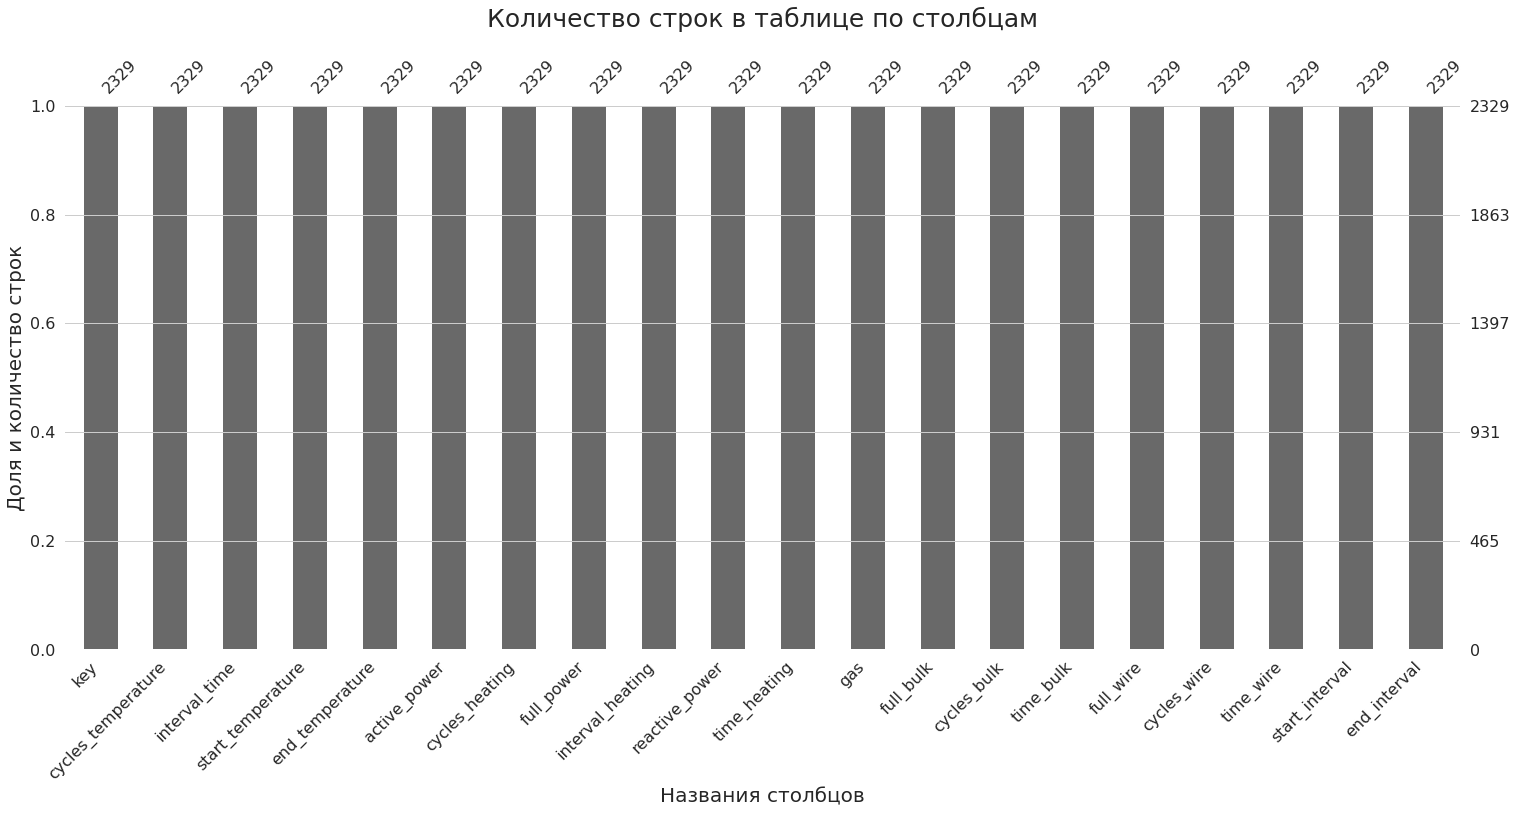

In [44]:
ax = msno.bar(data, labels=True)
ax.set_title('Количество строк в таблице по столбцам', fontsize=25, pad=30)
ax.set_xlabel('Названия столбцов', fontsize=20)
ax.set_ylabel('Доля и количество строк', fontsize=20)
plt.show()

In [45]:
missing_values('data', data, 0)


В таблице "data" отсутствуют пропущенные данные
---------------------------------------------------------------


* **~~Удаляем строки с пропущенными значениями~~**

In [46]:
#data = data.dropna()
#missing_values('data', data, 0)
#size('data', data)

**Проверяем наличие дубликатов в таблице**

In [47]:
duplicates('data', data, 0)


Дубликаты в таблице "data" отсутствуют
---------------------------------------------------------------


**~~Изменим тип данных в столбцах 'cycles_heating', 'cycles_bulk' и 'cycles_wire' на int~~**

In [48]:
#for c in ['cycles_heating', 'cycles_bulk', 'cycles_wire']:
    #data[c] = data[c].astype('int')
#data.info()

**Производим анализ признаков**


Производим анализ признаков таблицы "data":
---------------------------------------------------------------
Выводим уникальные значения признака ["cycles_temperature"]


array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17])

Строим диаграмму признака ["cycles_temperature"]


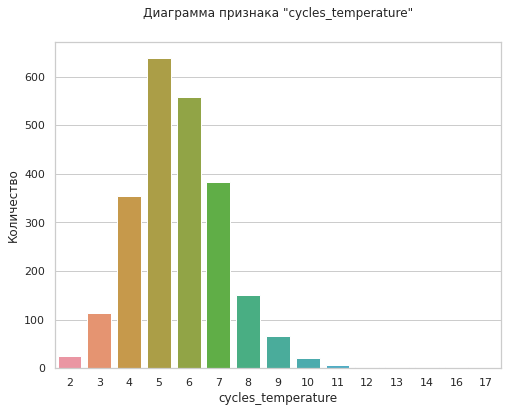

---------------------------------------------------------------
Выводим информацию о значениях признака ["interval_time"]


count     2329.000000
mean      2321.810219
std       1385.191527
min        270.000000
25%       1579.000000
50%       2045.000000
75%       2791.000000
max      23674.000000
Name: interval_time, dtype: float64

Строим гистограмму и диаграмму размаха признака ["interval_time"]


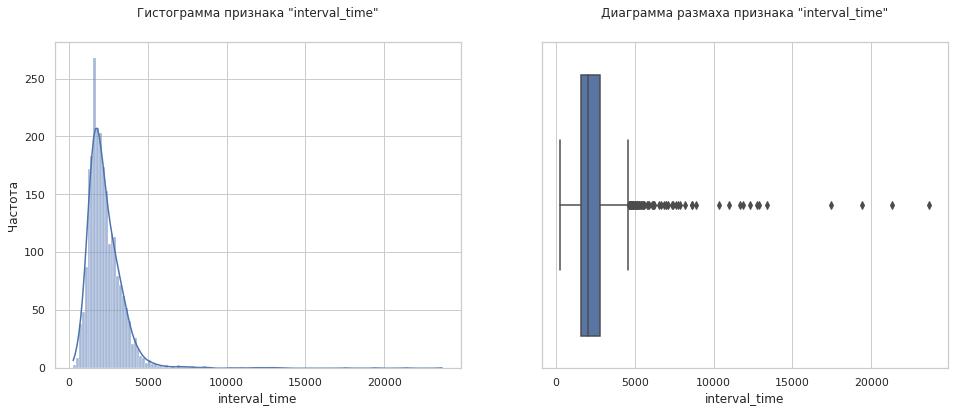

---------------------------------------------------------------
Выводим информацию о значениях признака ["start_temperature"]


count    2329.000000
mean     1587.386003
std        23.619841
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: start_temperature, dtype: float64

Строим гистограмму и диаграмму размаха признака ["start_temperature"]


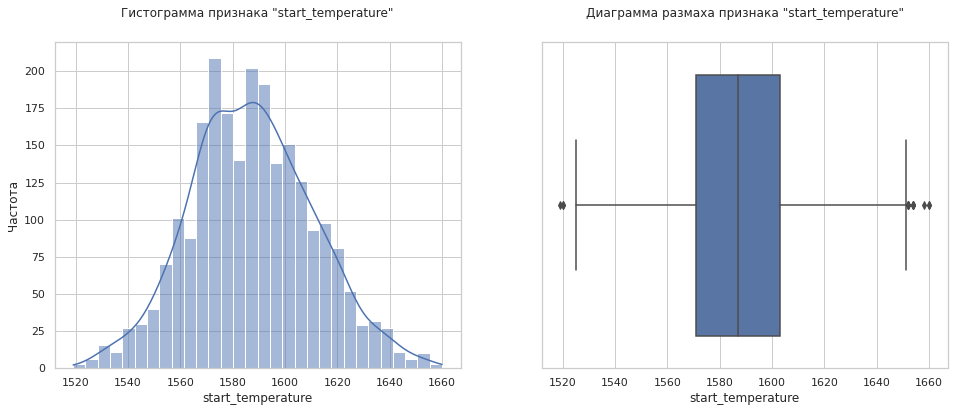

---------------------------------------------------------------
Выводим информацию о значениях признака ["end_temperature"]


count    2329.000000
mean     1593.365393
std        11.200915
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: end_temperature, dtype: float64

Строим гистограмму и диаграмму размаха признака ["end_temperature"]


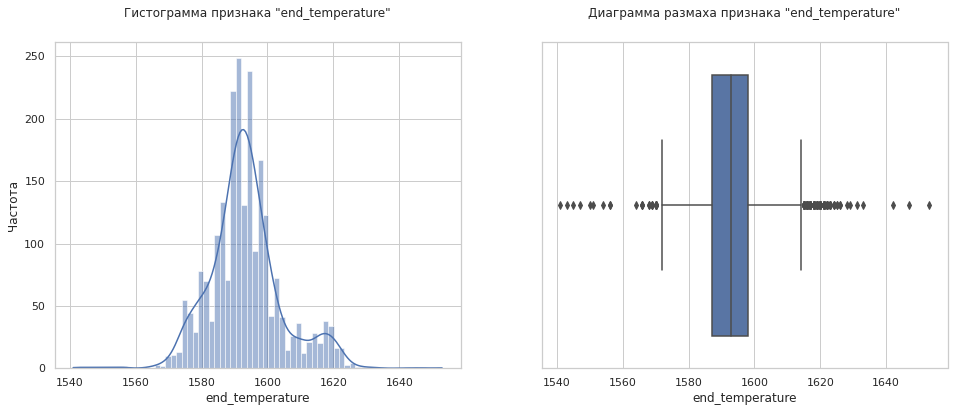

---------------------------------------------------------------
Выводим информацию о значениях признака ["active_power"]


count    2329.000000
mean        3.125336
std         1.220799
min         0.267676
25%         2.295820
50%         3.035365
75%         3.834300
max        12.375636
Name: active_power, dtype: float64

Строим гистограмму и диаграмму размаха признака ["active_power"]


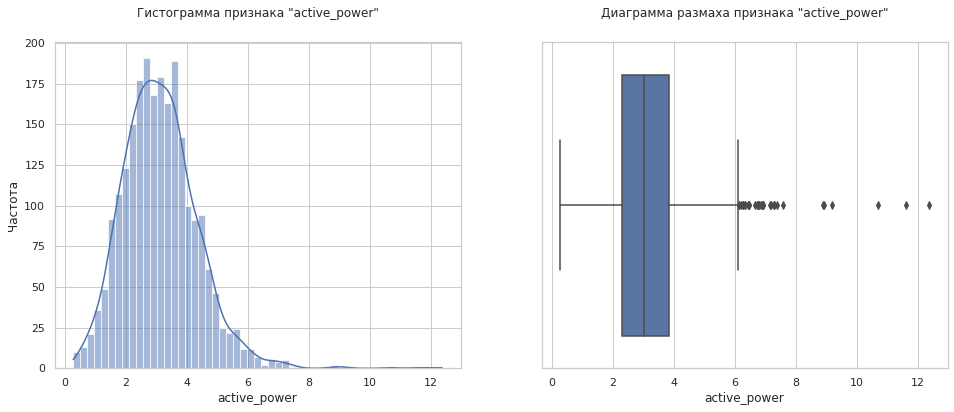

---------------------------------------------------------------
Выводим уникальные значения признака ["cycles_heating"]


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16])

Строим диаграмму признака ["cycles_heating"]


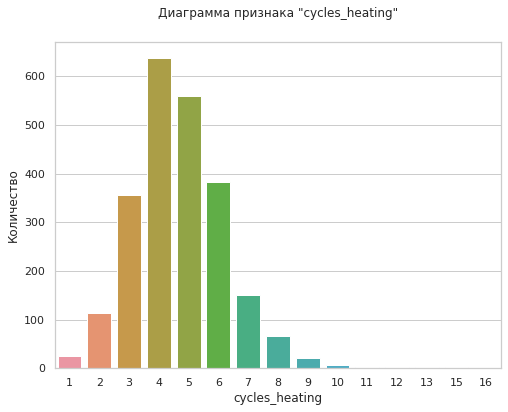

---------------------------------------------------------------
Выводим информацию о значениях признака ["full_power"]


count    2329.000000
mean        3.885026
std         1.517913
min         0.331897
25%         2.844193
50%         3.767499
75%         4.769421
max        15.288271
Name: full_power, dtype: float64

Строим гистограмму и диаграмму размаха признака ["full_power"]


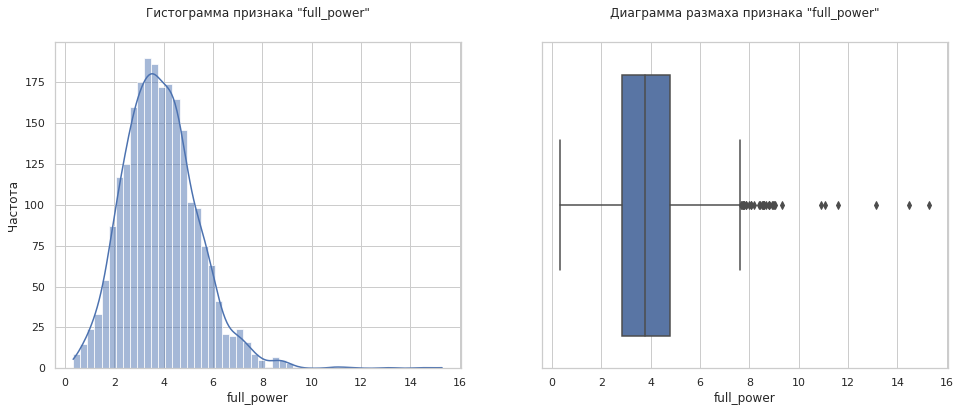

---------------------------------------------------------------
Выводим информацию о значениях признака ["interval_heating"]


count     2329.000000
mean      1184.657364
std       1156.702479
min          0.000000
25%        585.000000
50%        933.000000
75%       1507.000000
max      19296.000000
Name: interval_heating, dtype: float64

Строим гистограмму и диаграмму размаха признака ["interval_heating"]


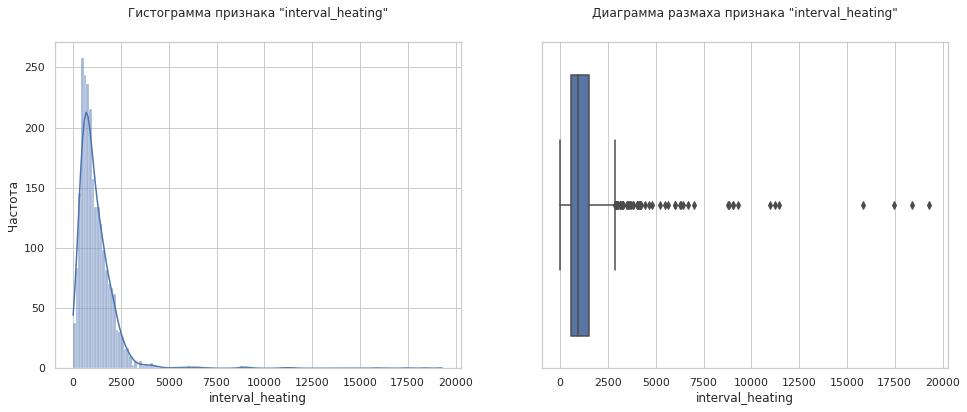

---------------------------------------------------------------
Выводим информацию о значениях признака ["reactive_power"]


count    2329.000000
mean        2.300739
std         0.903840
min         0.196228
25%         1.670519
50%         2.225398
75%         2.829159
max         8.949049
Name: reactive_power, dtype: float64

Строим гистограмму и диаграмму размаха признака ["reactive_power"]


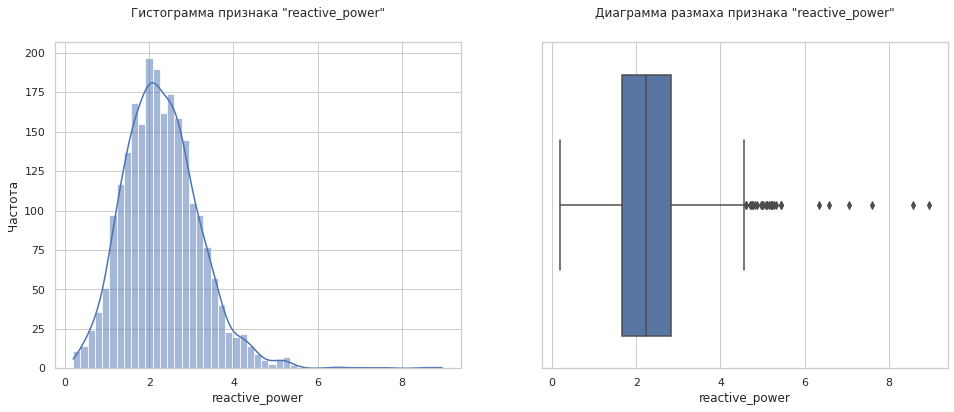

---------------------------------------------------------------
Выводим информацию о значениях признака ["time_heating"]


count    2329.000000
mean      807.647488
std       340.838388
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      4189.000000
Name: time_heating, dtype: float64

Строим гистограмму и диаграмму размаха признака ["time_heating"]


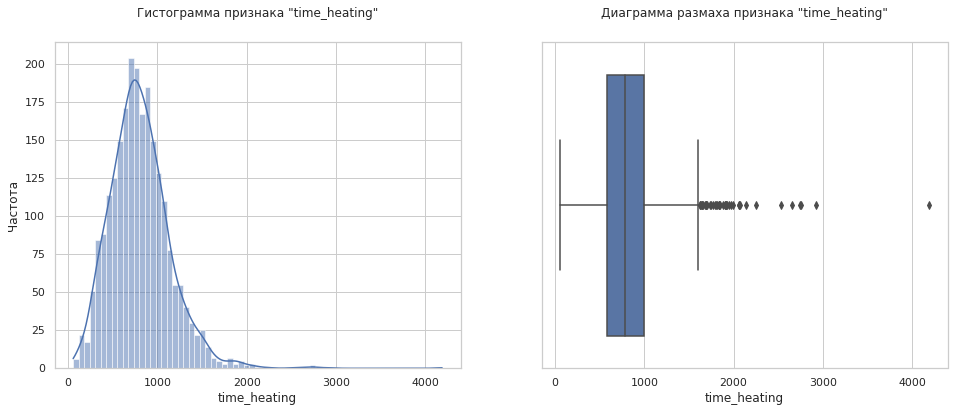

---------------------------------------------------------------
Выводим информацию о значениях признака ["gas"]


count    2329.000000
mean       11.375600
std         6.392041
min         0.008399
25%         7.282948
50%        10.100950
75%        14.216688
max        77.995040
Name: gas, dtype: float64

Строим гистограмму и диаграмму размаха признака ["gas"]


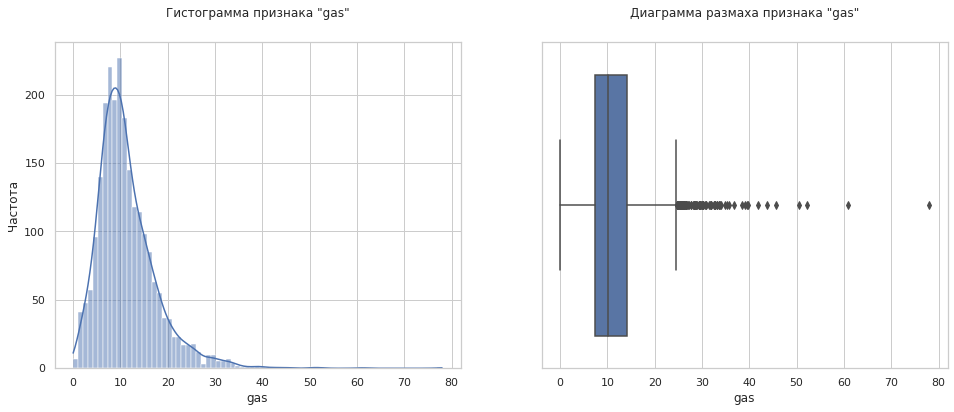

---------------------------------------------------------------
Выводим информацию о значениях признака ["full_bulk"]


count    2329.000000
mean      609.630313
std       287.599678
min        19.000000
25%       440.000000
50%       609.000000
75%       795.000000
max      3235.000000
Name: full_bulk, dtype: float64

Строим гистограмму и диаграмму размаха признака ["full_bulk"]


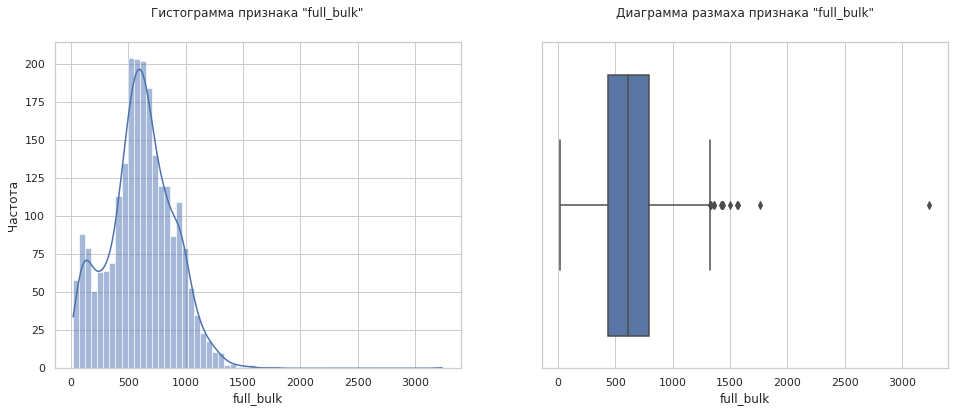

---------------------------------------------------------------
Выводим уникальные значения признака ["cycles_bulk"]


array([1, 2, 3, 4, 5, 6, 7])

Строим диаграмму признака ["cycles_bulk"]


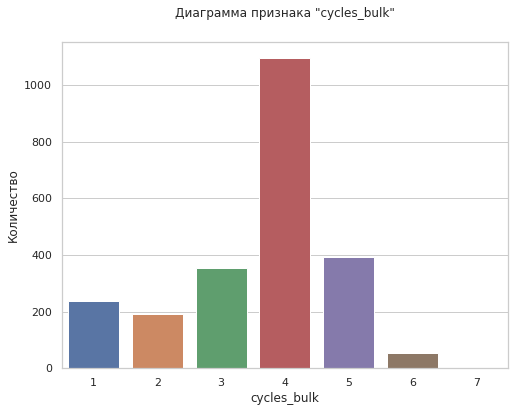

---------------------------------------------------------------
Выводим информацию о значениях признака ["time_bulk"]


count     2329.000000
mean       985.905968
std        815.668796
min          0.000000
25%        501.000000
50%        894.000000
75%       1340.000000
max      13683.000000
Name: time_bulk, dtype: float64

Строим гистограмму и диаграмму размаха признака ["time_bulk"]


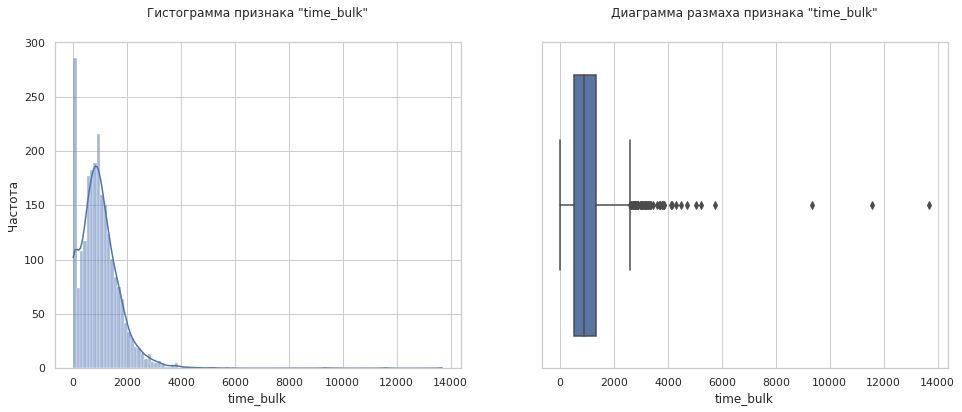

---------------------------------------------------------------
Выводим информацию о значениях признака ["full_wire"]


count    2329.000000
mean      125.208530
std        63.683386
min         1.918800
25%        89.013596
50%       116.101440
75%       151.568558
max       568.777664
Name: full_wire, dtype: float64

Строим гистограмму и диаграмму размаха признака ["full_wire"]


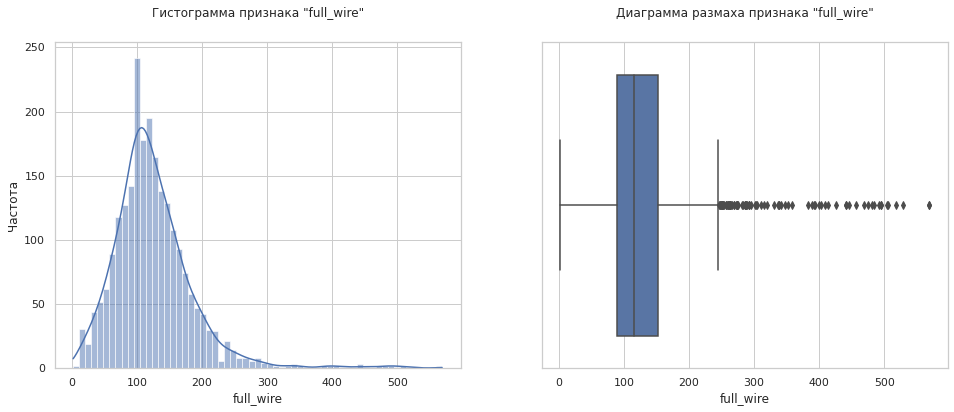

---------------------------------------------------------------
Выводим уникальные значения признака ["cycles_wire"]


array([1, 2, 3, 4, 5])

Строим диаграмму признака ["cycles_wire"]


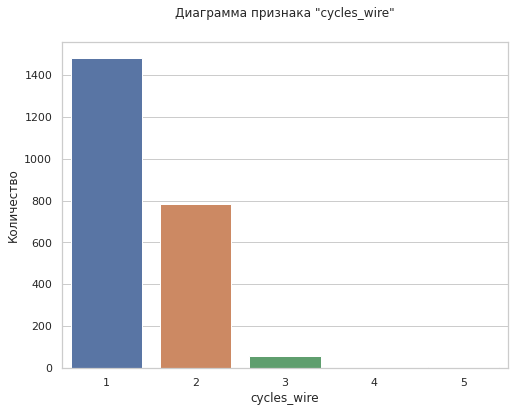

---------------------------------------------------------------
Выводим информацию о значениях признака ["time_wire"]


count    2329.000000
mean      209.708459
std       390.096311
min         0.000000
25%         0.000000
50%         0.000000
75%       396.000000
max      5937.000000
Name: time_wire, dtype: float64

Строим гистограмму и диаграмму размаха признака ["time_wire"]


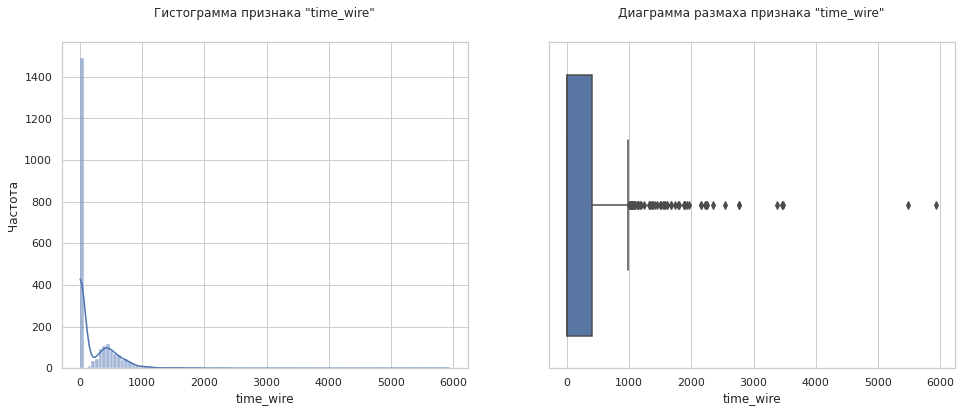

---------------------------------------------------------------
Выводим информацию о значениях признака ["start_interval"]


count    2329.000000
mean        8.910262
std        29.637647
min     -1003.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: start_interval, dtype: float64

Строим гистограмму и диаграмму размаха признака ["start_interval"]


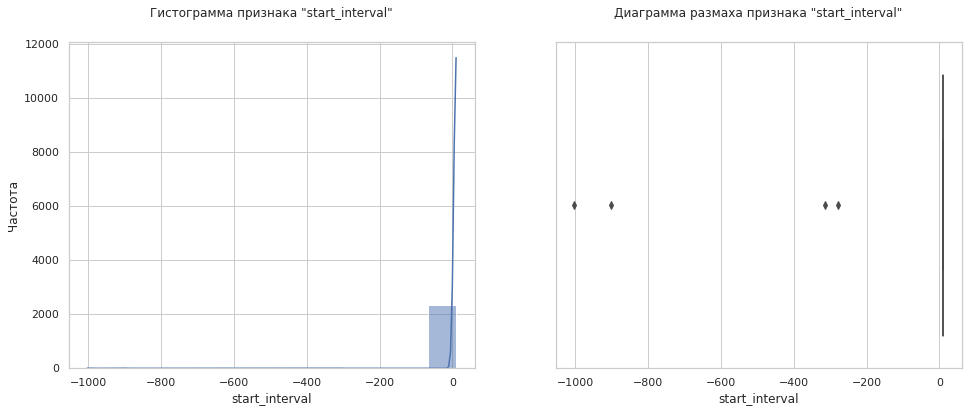

---------------------------------------------------------------
Выводим информацию о значениях признака ["end_interval"]


count    2329.000000
mean      320.595105
std       356.734383
min        20.000000
25%       174.000000
50%       258.000000
75%       370.000000
max      6963.000000
Name: end_interval, dtype: float64

Строим гистограмму и диаграмму размаха признака ["end_interval"]


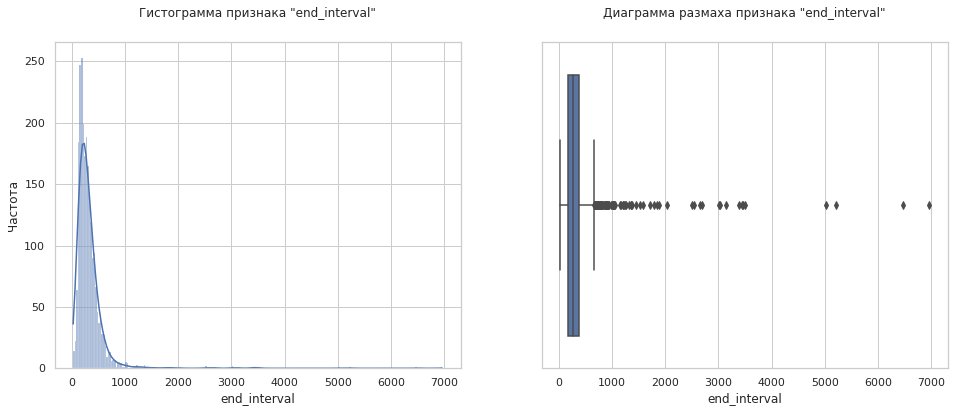

---------------------------------------------------------------


In [49]:
research('data', data, None)

* **Рассмотрим значения столбца 'start_interval'**

In [50]:
data['start_interval'].value_counts()

 10.0      2325
-314.0        1
-903.0        1
-278.0        1
-1003.0       1
Name: start_interval, dtype: int64

* ***В столбце 'start_interval' присутствуют отрицательные значения, то есть в этих партиях первый нагрев был раньше первого измерения температуры, в этом случае невозможно рассчитать необходимое время нагрева. Удалим строки с отрицательными значениями столбца. Все остальные значения одинаковые, в этом случае этот признак не имеет смысла, поэтому его удаляем***

In [51]:
data = data.drop(data[data['start_interval'] < 0].index, axis=0).reset_index(drop=True)
data = data.drop('start_interval', axis=1)

**Проводим корреляционный анализ признаков таблицы**

In [52]:
#interval_cols = ['interval_time', 'start_temperature', 'end_temperature', 'max_temperature', 'min_temperature', 'active_power', \
                #'full_power', 'interval_heating', 'reactive_power', 'time_heating', 'gas', 'full_bulk', 'time_bulk', \
                #'full_wire', 'time_wire', 'end_interval']
#phik_overview = phik_matrix(data.drop('key', axis=1), interval_cols=interval_cols)
#plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, vmin=0, vmax=1,
                        #color_map='coolwarm', title=r'correlation $\phi_K$', fontsize_factor=1.5, figsize=(20, 10))

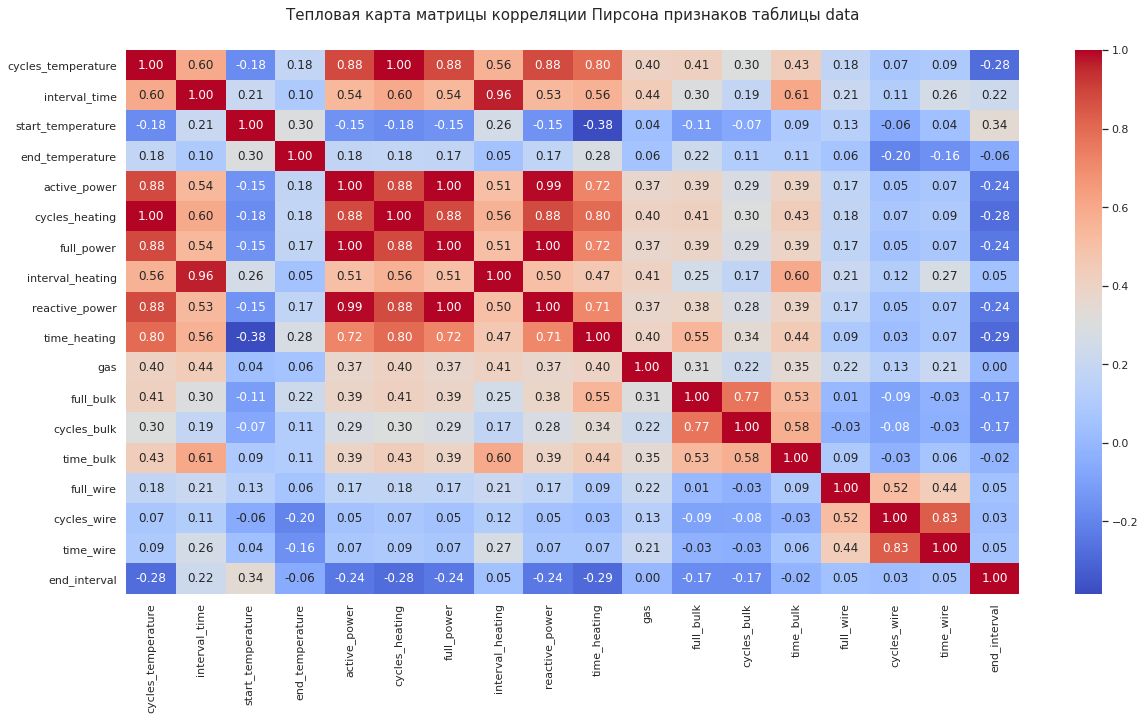

In [53]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.drop('key', axis=1).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Тепловая карта матрицы корреляции Пирсона признаков таблицы data', fontsize=15, pad=30)
plt.show()

* ***Для устранения мультиколлинеарности удалим признаки 'cycles_temperature', ~~'cycles_heating',~~ 'active_power', 'reactive_power' и 'interval_heating'***

In [54]:
data = data.drop(['cycles_temperature', 'active_power', 'reactive_power', 'interval_heating'], axis=1)

#interval_cols = ['interval_time', 'start_temperature', 'end_temperature', 'max_temperature', 'min_temperature', \
                #'full_power', 'time_heating', 'gas', 'full_bulk', 'time_bulk', 'full_wire', 'time_wire', 'end_interval']
#phik_overview = phik_matrix(data.drop('key', axis=1), interval_cols=interval_cols)
#plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, vmin=0, vmax=1,
                        #color_map='coolwarm', title=r'correlation $\phi_K$', fontsize_factor=1.5, figsize=(20, 10))

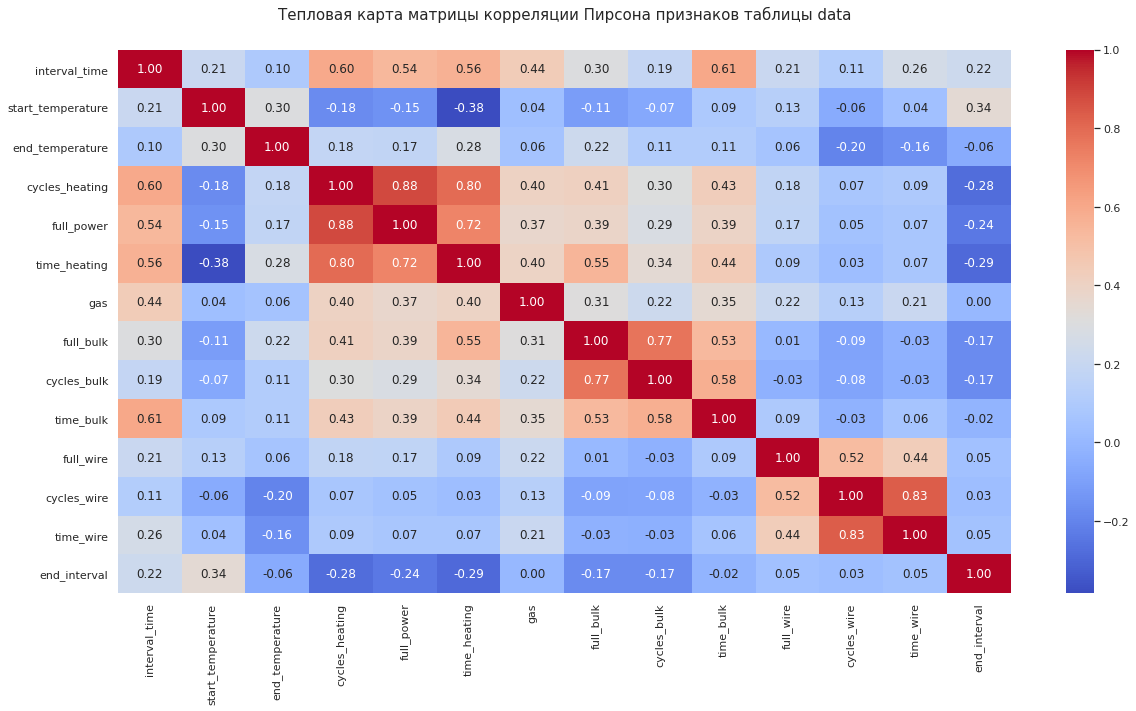

In [55]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.drop('key', axis=1).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Тепловая карта матрицы корреляции Пирсона признаков таблицы data', fontsize=15, pad=30)
plt.show()

***Произведён исследовательский анализ и предобработка данных***
* ~~удалены~~ пропущенные значения отсутствуют
* дубликаты строк в таблице отсутствуют
* ~~изменены типы данных в столбцах 'cycles_heating', 'cycles_bulk' и 'cycles_wire' на int~~
* большинство признаков имеют распределение похожее на нормальное, присутствуют выбросы
* в столбце 'start_interval' присутствуют отрицательные значения, то есть в этих партиях первый нагрев был раньше первого измерения температуры, в этом случае невозможно рассчитать необходимое время нагрева. Удалим строки с отрицательными значениями столбца. Все остальные значения одинаковые, в этом случае этот признак не имеет смысла, поэтому его удаляем
* для устранения мультиколлинеарности удалены признаки 'cycles_temperature', ~~'cycles_heating',~~ 'active_power', 'reactive_power' и 'interval_heating'

## Шаг 5. Подготовка данных

**Выделяем выборки с входными и целевыми тренировочными и тестовыми данными**

In [56]:
X = data.drop(['key', 'end_temperature'], axis=1)
y = data['end_temperature']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

size('X_train', X_train)
size('X_test', X_test)


Таблица "X_train" содержит 1743 строк и 13 столбцов
---------------------------------------------------------------

Таблица "X_test" содержит 582 строк и 13 столбцов
---------------------------------------------------------------


**Создаём списки с названиями признаков и пайплайн для подготовки признаков**

In [57]:
num_columns = X_train.columns.tolist()

data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)
    ], remainder='passthrough')

***На этапе подготовки данных были проведены следующие действия:***
* были выделены выборки с входными и целевыми тренировочными и тестовыми данными
* создан список с названиями признаков и пайплайн для подготовки признаков
* признаки будут масштабированы с помощью StandardScaler и MinMaxScaler

## Шаг 6. Обучение моделей машинного обучения

**Создаём итоговый пайплайн для подготовки данных и моделей. В качестве моделей будем использовать DecisionTreeRegressor и LinearRegression. Производим обучение моделей, определяем параметры лучшей модели, выводим метрику MAE на тренировочной выборке**

In [58]:
pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))])

param_grid = [
    {'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': range(2, 14),
     'models__max_features': range(2, 14),
     'models__min_samples_leaf': range(1, 5),
     'models__min_samples_split': range(2, 7),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    {'models': [LinearRegression()],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

randomized_search = RandomizedSearchCV(pipe_final, param_grid, cv=10, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE, n_jobs=-1)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_ * -1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['interval_time',
                                                   'start_temperature',
                                                   'cycles_heating',
                                                   'full_power', 'time_heating',
                                                   'gas', 'full_bulk',
                                                   'cycles_bulk', 'time_bulk',
                                                   'full_wire', 'cycles_wire',
                                                   'time_wire',
                                                   'end_interval'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=3, max_features=7,
                                       min_samples

***В процессе обучения моделей были проведены следующие действия:***
* создан итоговый пайплайн для подготовки данных и моделей. Производено обучение двух моделей: DecisionTreeRegressor и LinearRegression, в качестве метрики определяем MAE, определены параметры лучшей модели, выведена метрика
* получены параметры лучшей модели: DecisionTreeRegressor с гиперпараметрами max_depth=3, max_features=7, min_samples_leaf=3
* значение метрики MAE на тестовой выборке равно 7,9

## Шаг 7. Выбор лучшей модели

**По итогам предыдущего шага лучшей моделью определена DecisionTreeRegressor (max_depth=9, max_features=12). Сделаем предсказание этой модели на тестовой выборке и определим метрику MAE**

In [59]:
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика MAE на тестовой выборке: {mean_absolute_error(y_test, y_test_pred)}')

Метрика MAE на тестовой выборке: 6.78330596639051


* ***Модель показала на тестовой выборке метрику, устраивающую заказчика MAE = 6,8 <= 6,8***

**Произведём проверку модели на адекватность константной моделью**

In [60]:
X_train_new = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train)
transf_col_names = randomized_search.best_estimator_['preprocessor'].get_feature_names_out()
X_train_new = pd.DataFrame(X_train_new, columns=transf_col_names)

X_test_new = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
X_test_new = pd.DataFrame(X_test_new, columns=transf_col_names)


dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train_new, y_train)
dummy_y_test_pred = dummy_model.predict(X_test_new)
print(f'Метрика MAE модели Dummy на тестовой выборке: {mean_absolute_error(y_test, dummy_y_test_pred)}')

Метрика MAE модели Dummy на тестовой выборке: 7.391193640541542


* ***Модель DummyRegressor показала метрику MAE на тестовой выборке 7,4, что больше метрики, показанной лучшей моделью. Следовательно, лучшая модель прошла проверку на адекватность***

**Произведём анализ важности признаков**

  0%|          | 0/10 [00:00<?, ?it/s]

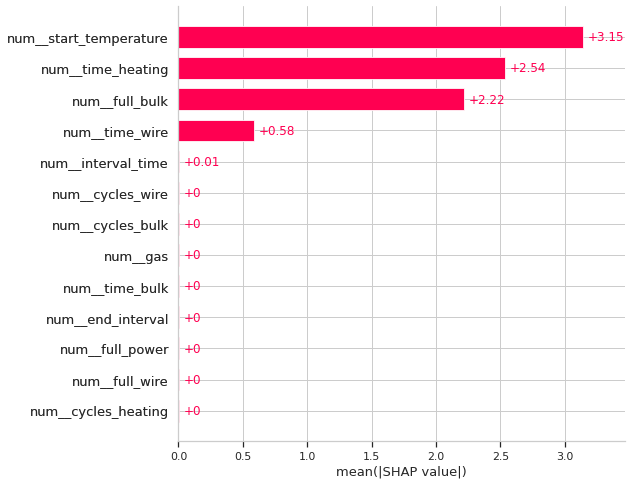

In [61]:
best_model = randomized_search.best_estimator_.named_steps['models']
#explainer = shap.LinearExplainer(best_model, X_train_new)
#shap_values = explainer(X_train_new)
#shap.plots.bar(shap_values, max_display=17)

X_train_new_sam = shap.sample(X_train_new, nsamples=10)
explainer_sec = shap.KernelExplainer(best_model.predict, X_train_new_sam)
shap_values_sec = explainer_sec(X_train_new_sam)
shap.plots.bar(shap_values_sec, max_display=17)

* ***На целевой признак больше всего влияют следующие признаки: 'start_temperature', 'time_heating', 'full_bulk' и 'time_wire'***

***В процессе выбора лучшей модели сделаны следующие шаги:***
* лучшая модель показала на тестовой выборке метрику, устраивающую заказчика MAE = 6,8 <= 6,8
* в ходе проверки лучшей модели на адекватность модель DummyRegressor показала метрику MAE на тестовой выборке 7,4, что больше метрики, показанной лучшей моделью. Следовательно, лучшая модель прошла проверку на адекватность
* на целевой признак больше всего влияют следующие признаки: 'start_temperature', 'time_heating', 'full_bulk' и 'time_wire'
* с помощью этой модели можно делать прогноз о температуре сплава

## Шаг 8. Общий вывод и рекомендации заказчику

***Металлургический комбинат «Стальная птица» обратился к нам с задачей уменьшения потребления электроэнергии на этапе обработки стали. Наша задача - предсказать температуру сплава. Сплав поготавливается следующим образом - в специальный ковш подаётся расплавленная сталь, далее она подогревается до нужной температуры с помощью электродов, в неё подаются добавки и продувают инертным газом. В течении этого процесса производятся замеры температуры и химический анализ сплава. При достижении нужных параметров сталь поступает в машину непрерывной разливки***

***Для проведения исследования получены 7 файлов с данными:***
* data_arc_new.csv - с данными об электродах
* data_bulk_new.csv - с данные об объёме подачи сыпучих материалов
* data_bulk_time_new.csv - с данными о времени подачи сыпучих материалов
* data_gas_new.csv - с данными о продувке сплава газом
* data_temp_new.csv - с результатами измерения температуры
* data_wire_new.csv - с данными об объёме подачи проволочных материалов
* data_wire_time_new.csv - с данными о времени подачи проволочных материалов

***С этими файлами были произведены следующие действия:***
* загружены и сохранены данные используя библиотеку pandas, даты приведены к формату 'datetime'
* выведены первые строки таблиц
* получена общая информация о таблицах

***Изучив данные можно сделать следующие выводы:***
* в таблицах присутствуют данные количественные, категориальные и обозначающие дату и время: номер партии, время начала и окончания нагрева, объём и время подачи материала, объём подаваемого газа, значение температуры и время её замера, объём и время подачи проволочных материалов
* в названиях столбцов присутствуют символы в верхнем регистре, пробелы и кириллица. Приводим названия столбцов к общепринятому стилю: латиница, нижний регистр и нижнее подчёркивание в качестве разделителя
* в некоторых таблицах присутствуют пропущенные данные
* в таблице 'data_arc_new' присутствует аномалия - отрицательное значение в столбце 'реактивная мощность'. В других таблицах явных аномалий не наблюдается
* таблица 'data_temp_new' содержит целевой признак - последнее значение температуры
* типы данных во всех таблицах соответствует назначению данных

***Произведён исследовательский анализ и предобработка первоначальных данных***
* в парах таблиц 'data_bulk_new' - 'data_bulk_time_new' и 'data_wire_new' - 'data_wire_time_new' присутствует одинаковое количество пропущенных данных в столбцах с одним названием, что говорит о том, что если отсутствует данные об объёме подачи сыпучих или проволочных материалов, то также отсутствуют и данные о времени подачи этих материалов. Делаем вывод, что отсутствующие значения обозначают, что материалы не подавались в этом шаге, следовательно они заменены на значение 0
* удалены данные тех партий в таблице 'data_temp_new', у которых пропущено последнее значение температуры, так как это значение является целевым признаком
* в таблицах отсутствуют дубликаты
* в таблице 'data_arc_new' присутствует отрицательное значение реактивной мощности, это значение считаем аномалией и заменяем на среднее значение реактивной мощности в этой партии
* в таблице 'data_temp_new' в столбце 'temperature' наблюдаются аномальные значения в диапазоне менее 1300, удаляем эти значения
* добавлены в таблицу 'data_arc_new' столбцы с полной мощностью, временем нагрева, интервалами между нагревами и количеством циклов нагрева в каждой партии
* создана сводная таблица на базе таблицы 'data_arc_new' с суммарными значениями для каждой партии
* добавлены в таблицу 'data_bulk_new' столбцы с суммой объёма подачи сыпучих материалов и количеством подач. Удалены столбцы 'bulk'
* добавлено в таблицу 'data_bulk_time_new' время, прошедшее с начала добавления сыпучих материалов до окончания. Удалены столбцы 'bulk'
* добавлены в таблицу 'data_wire_new' столбцы с суммой объёма подачи проволочных материалов и количеством подач. Удалены столбцы 'wire'
* добавлено в таблицу 'data_wire_time_new' время, прошедшее с начала добавления проволочных материалов до окончания. Удалены столбцы 'wire'
* добавлены в таблицу 'data_temp_new' столбцы с интервалами между замерами температуры и количеством циклов замеров
* создана сводная таблица на базе таблицы 'data_temp_new' с суммарными значениями для каждой партии, оставлены начальное и конечное значения температур - целевой признак

***Произведено объединение таблиц по столбцу 'key'. Добавлены в таблицу два новых столбца: время прошедшее с момента первого замера температуры до первого нагрева и время с момента последнего нагрева до последнего замера температуры. Удалены столбцы с датами, которые больше не планируется использовать. Выводена общую информацию об объединённой таблице, она содержит 2329 строк и 20 столбцов***

***Произведён исследовательский анализ и предобработка данных объединённой таблицы***
* пропущенные значения отсутствуют
* дубликаты строк в таблице отсутствуют
* большинство признаков имеют распределение похожее на нормальное, присутствуют выбросы
* в столбце 'start_interval' присутствуют отрицательные значения, то есть в этих партиях первый нагрев был раньше первого измерения температуры, в этом случае невозможно рассчитать необходимое время нагрева. Удалим строки с отрицательными значениями столбца. Все остальные значения одинаковые, в этом случае этот признак не имеет смысла, поэтому его удаляем
* для устранения мультиколлинеарности удалены признаки 'cycles_temperature', 'active_power', 'reactive_power' и 'interval_heating'

***На этапе подготовки данных были проведены следующие действия:***
* были выделены выборки с входными и целевыми тренировочными и тестовыми данными
* создан список с названиями признаков и пайплайн для подготовки признаков
* признаки будут масштабированы с помощью StandardScaler и MinMaxScaler

***В процессе обучения моделей были проведены следующие действия:***
* создан итоговый пайплайн для подготовки данных и моделей. Производено обучение двух моделей: DecisionTreeRegressor и LinearRegression, в качестве метрики определяем MAE, определены параметры лучшей модели, выведена метрика
* получены параметры лучшей модели: DecisionTreeRegressor с гиперпараметрами max_depth=3, max_features=7, min_samples_leaf=3
* значение метрики MAE на тестовой выборке равно 7,9

***В процессе выбора лучшей модели сделаны следующие шаги:***
* лучшая модель показала на тестовой выборке метрику, устраивающую заказчика MAE = 6,8 <= 6,8
* в ходе проверки лучшей модели на адекватность модель DummyRegressor показала метрику MAE на тестовой выборке 7,4, что больше метрики, показанной лучшей моделью. Следовательно, лучшая модель прошла проверку на адекватность
* на целевой признак больше всего влияют следующие признаки: 'start_temperature', 'time_heating', 'full_bulk' и 'time_wire'
* с помощью этой модели можно делать прогноз о температуре сплава

***Предложение для предприятия***
* для повышения качества прогнозирования необходимо улучшить качество собираемых данных, так как в существующих имеется большое количество данных, которые пришлось удалить
* особое внимание стоит обратить на качество сбора информации о температуре, времени нагрева, количестве сыпучих материалов и времени подачи проволочных материалов